<a href="https://colab.research.google.com/github/M-Taha-98/Sales-and-Profitability-Analysis/blob/main/Superstore_Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Superstore Sales Profitability Analysis**

##Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re

## Read/Explore Dataset

In [3]:
import requests

# URL of the raw Excel file in GitHub
url = 'https://raw.githubusercontent.com/M-Taha-98/Sales-and-Profitability-Analysis/main/Superstore%20Dataset%20raw.csv'


# Path to save the file in Colab's local storage
file_path = '/content/Superstore Dataset raw.csv'

# Download the file from GitHub
r = requests.get(url)

# Save the content to the local file system
with open(file_path, 'wb') as f:
    f.write(r.content)

# Now read the data using pandas
import pandas as pd
raw_data = pd.read_csv(file_path, encoding='latin1')

# Display the first few rows
raw_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
raw_data.shape  #9994 rows and 21 columns in raw dataset

(9994, 21)

In [5]:
raw_data.info()

# The data type for Order Date and Ship Date needs to be changed to datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [6]:
raw_data.isnull().sum()  #no missing values

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [7]:
#Statistical Summary

raw_data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


## Data Pre-processing

####Drop extra columns

In [8]:
# Creating a copy of dataframe to use in analysis

df = raw_data.copy()

In [9]:
# Dropping columns redundant column not useful for analysis

df.drop(columns = ["Country"], inplace = True)  #drop Country column

In [10]:
df.shape

(9994, 20)

####Data type correction

In [11]:
# Correcting datatype from string to datetime

df['Order Date'] = pd.to_datetime(df['Order Date'], format = '%m/%d/%Y')

In [12]:
# Correcting datatype from string to datetime

df['Ship Date'] = pd.to_datetime(df['Ship Date'], format = '%m/%d/%Y')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   City           9994 non-null   object        
 9   State          9994 non-null   object        
 10  Postal Code    9994 non-null   int64         
 11  Region         9994 non-null   object        
 12  Product ID     9994 non-null   object        
 13  Category       9994 non-null   object        
 14  Sub-Category   9994 non-null   object        
 15  Product Name   9994 n

####Data Validation

In [14]:
# Validating that all Ship Dates follow or are equal to Order Date and not the other way around

len(df[df['Ship Date'] > df['Order Date']])

9475

In [15]:
len(df[df['Ship Date'] == df['Order Date']])  #543-519 = 24 order IDs have been delayed (were same day shipping but not shipped the same day)

519

In [16]:
df['Ship Mode'].value_counts()

,count
Ship Mode,
Standard Class,5968
Second Class,1945
First Class,1538
Same Day,543


####Statistical Summary

In [17]:
# Including only numeric features

df.describe(include= ['int64','float64'])

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


**Observations:**
  - Majority (75% of data) is on the lower end of pricing and hence the generated profit.
  - 75% of data lies below sale price of approx  `$209` while max sale price is `$22,600` which indicates presence of outliers.

  - Majority (75%) of items bought from this store are discounted at 20%, few items do have larger discounts such as 80%.

  - Superstore has incurred loss (negative profit) on some orders.

In [18]:
# Including only non-numeric features

df.describe(include= ['object'])

,Order ID,Ship Mode,Customer ID,Customer Name,Segment,City,State,Region,Product ID,Category,Sub-Category,Product Name
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994
unique,5009,4,793,793,3,531,49,4,1862,3,17,1850
top,CA-2017-100111,Standard Class,WB-21850,William Brown,Consumer,New York City,California,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope
freq,14,5968,37,37,5191,915,2001,3203,19,6026,1523,48


- There is no errors in customer ID and customer name columns, each customer is represented by unique customer ID.
- The most common shipping method is Standard Class.
- Wlliam Brown has placed most orders i.e. 37.
- A customer can place more than one order on same/different day hence there will be duplicate rows which is not an issue in the dataset.
- The most ordered item is Staple envelope.
- Consumer segment has placed the most number of orders, but that doesnot necessarily mean it brings in most sales.
- Similarly most orders are for Office Supplies, but that doesnot necessarily mean it brings in most sales.
- Most orders have been shipped to California, but is that the state bringing in most revenue?

####Duplicate Values

In [19]:
# Checking for duplicates in the data

df.duplicated().sum()  #no duplicates

np.int64(0)

In [20]:
df.duplicated(subset=["Customer ID"]).sum()  #since a customer can place ore than 1 order, duplicates are not an issue

np.int64(9201)

## Data Transformation

####Data Cleaning

**Remove leading and trailing spaces:**

In [21]:
# Define function to remove leading and trailing characters

for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.strip()

**Remove any leading or trailing unwanted characters from customer name:**

In [22]:
df[df['Customer Name'].str.contains('Jason', case=False, na=False)].sample(4)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7360,7361,CA-2016-163594,2016-04-12,2016-04-14,First Class,JF-15295,Jason Fortune-,Consumer,Los Angeles,California,90036,West,OFF-PA-10000809,Office Supplies,Paper,Xerox 206,19.440,3,0.0,9.3312
6149,6150,CA-2017-101322,2017-12-28,2017-12-31,First Class,JG-15310,Jason Gross,Corporate,Long Beach,California,90805,West,FUR-CH-10003968,Furniture,Chairs,Novimex Turbo Task Chair,340.704,6,0.2,-34.0704
5343,5344,US-2014-168501,2014-11-21,2014-11-27,Standard Class,JK-15325,Jason Klamczynski,Corporate,Dallas,Texas,75220,Central,TEC-PH-10004922,Technology,Phones,RCA Visys Integrated PBX 8-Line Router,267.960,5,0.2,16.7475
3291,3292,CA-2016-167290,2016-10-30,2016-11-04,Standard Class,JF-15295,Jason Fortune-,Consumer,Sterling Heights,Michigan,48310,Central,OFF-AR-10004078,Office Supplies,Art,Newell 312,11.680,2,0.0,3.5040


- Jason Fortune- is an error since there is an unwanted trailing character which needs to be cleaned.

In [23]:
# Define custom function to remove unwanted characters from Customer Name field

def clean_edges(text):
    if isinstance(text, str):  # check if input is a string
        return re.sub(r"^[^a-zA-Z]+|[^a-zA-Z]+$", "", text) # remove anything except alphabets from start and end
    else:
        return text  # if it's not a string (maybe NaN), return as it is

In [24]:
df['Customer Name'] = df['Customer Name'].apply(clean_edges)

**Capitalizing the Customer ID and Order ID:**

In [25]:
df['Customer ID'] = df['Customer ID'].str.upper()
df['Order ID'] = df['Order ID'].str.upper()

**Replace empty string with Null in object columns:**

In [26]:
# Define function to replace empty string with Null

def clean_nulls(text):
    if isinstance(text, str):   # check if input is a string
        if text.lower() == 'n/a':
            return None
        elif text == '':
            return np.nan
        else:
            return text
    else:
        return text

In [27]:
for col in df.select_dtypes(include='object'):
    df[col] = df[col].apply(clean_nulls)

In [28]:
print(f"The order date ranges between {df['Order Date'].dt.year.min()} and {df['Order Date'].dt.year.max()}")
print(f"The ship date ranges between {df['Ship Date'].dt.year.min()} and {df['Ship Date'].dt.year.max()}")

The order date ranges between 2014 and 2017
The ship date ranges between 2014 and 2018


####Adding Custom Columns

In [29]:
# Adding Cost Column

df['Cost'] = df['Sales'] - df['Profit']

In [30]:
# Adding Delay Column

df['Delay'] = df['Ship Date'] - df['Order Date']

In [31]:
# Adding Gross Sales column

df['PreDiscountSales'] = df['Sales'] / (1 - df['Discount'])

In [32]:
# Overall Profit by Date of Order

b = df.groupby('Order Date')['Profit'].sum()

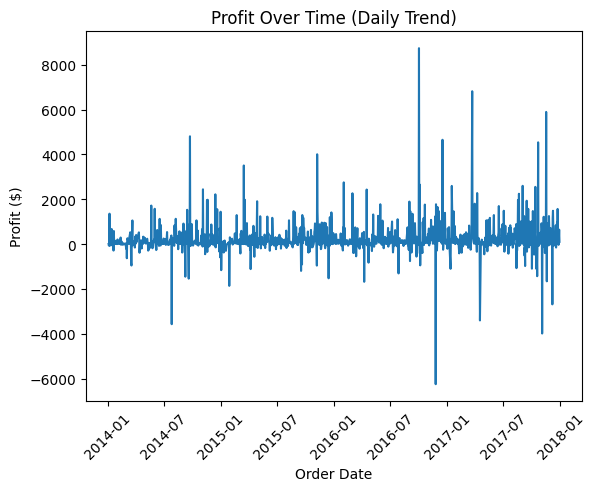

In [33]:
plt.plot(b.index, b.values)

plt.xlabel('Order Date')
plt.ylabel('Profit ($)')
plt.title('Profit Over Time (Daily Trend)')
plt.xticks(rotation=45)

plt.show()

## Non-Graphical Analysis

In [34]:
categorical  = df.select_dtypes(include = "object")

In [35]:
for i in categorical:
  print(f"{i} has {df[i].nunique()} values")
  print(f"{df[i].unique()}\n")

Order ID has 5009 values
['CA-2016-152156' 'CA-2016-138688' 'US-2015-108966' ... 'CA-2014-110422'
 'CA-2017-121258' 'CA-2017-119914']

Ship Mode has 4 values
['Second Class' 'Standard Class' 'First Class' 'Same Day']

Customer ID has 793 values
['CG-12520' 'DV-13045' 'SO-20335' 'BH-11710' 'AA-10480' 'IM-15070'
 'HP-14815' 'PK-19075' 'AG-10270' 'ZD-21925' 'KB-16585' 'SF-20065'
 'EB-13870' 'EH-13945' 'TB-21520' 'MA-17560' 'GH-14485' 'SN-20710'
 'LC-16930' 'RA-19885' 'ES-14080' 'ON-18715' 'PO-18865' 'LH-16900'
 'DP-13000' 'JM-15265' 'TB-21055' 'KM-16720' 'PS-18970' 'BS-11590'
 'KD-16270' 'HM-14980' 'JE-15745' 'KB-16600' 'SC-20770' 'DN-13690'
 'JC-16105' 'CS-12400' 'PG-18895' 'GM-14455' 'JS-15685' 'KB-16315'
 'RB-19705' 'PN-18775' 'KD-16345' 'ER-13855' 'RB-19465' 'GZ-14470'
 'LC-16870' 'JM-15250' 'PA-19060' 'CV-12805' 'CL-12565' 'RC-19960'
 'DK-13090' 'GG-14650' 'SC-20725' 'AD-10180' 'PF-19165' 'TS-21610'
 'LS-16975' 'DW-13585' 'LC-16885' 'JD-15895' 'SH-19975' 'SG-20080'
 'HA-14920' 'MG-17

In [36]:
for i in categorical:
  display(df[i].value_counts(normalize = True)*100)

,proportion
Order ID,
CA-2017-100111,0.140084
CA-2017-157987,0.120072
CA-2016-165330,0.110066
US-2016-108504,0.110066
US-2015-126977,0.100060
...,...
CA-2014-110422,0.010006
CA-2016-125794,0.010006
CA-2017-163566,0.010006


,proportion
Ship Mode,
Standard Class,59.715829
Second Class,19.461677
First Class,15.389234
Same Day,5.433260


,proportion
Customer ID,
WB-21850,0.370222
MA-17560,0.340204
JL-15835,0.340204
PP-18955,0.340204
CK-12205,0.320192
...,...
AO-10810,0.010006
LD-16855,0.010006
JR-15700,0.010006


,proportion
Customer Name,
William Brown,0.370222
Matt Abelman,0.340204
John Lee,0.340204
Paul Prost,0.340204
Chloris Kastensmidt,0.320192
...,...
Anthony O'Donnell,0.010006
Lela Donovan,0.010006
Jocasta Rupert,0.010006


,proportion
Segment,
Consumer,51.941165
Corporate,30.218131
Home Office,17.840704


,proportion
City,
New York City,9.155493
Los Angeles,7.474485
Philadelphia,5.373224
San Francisco,5.103062
Seattle,4.282570
...,...
Abilene,0.010006
Montebello,0.010006
Kissimmee,0.010006


,proportion
State,
California,20.022013
New York,11.286772
Texas,9.855914
Pennsylvania,5.873524
Washington,5.063038
Illinois,4.922954
Ohio,4.692816
Florida,3.832299
Michigan,2.551531


,proportion
Region,
West,32.049230
East,28.497098
Central,23.243946
South,16.209726


,proportion
Product ID,
OFF-PA-10001970,0.190114
TEC-AC-10003832,0.180108
FUR-FU-10004270,0.160096
FUR-CH-10002647,0.150090
FUR-CH-10001146,0.150090
...,...
TEC-MA-10004552,0.010006
TEC-MA-10003589,0.010006
OFF-AP-10003099,0.010006


,proportion
Category,
Office Supplies,60.296178
Furniture,21.222734
Technology,18.481089


,proportion
Sub-Category,
Binders,15.239143
Paper,13.708225
Furnishings,9.575745
Phones,8.895337
Storage,8.465079
Art,7.964779
Accessories,7.754653
Chairs,6.173704
Appliances,4.662798


,proportion
Product Name,
Staple envelope,0.480288
Staples,0.460276
Easy-staple paper,0.460276
Avery Non-Stick Binders,0.200120
Staples in misc. colors,0.190114
...,...
Xiaomi Mi3,0.010006
"Sanitaire Vibra Groomer IR Commercial Upright Vacuum, Replacement Belts",0.010006
Holmes Harmony HEPA Air Purifier for 17 x 20 Room,0.010006


## Bivariate Analysis

###### **Sales vs Category / Sub-Category:** Compare Sales across product categories and subcategories

In [37]:
# Sales across Product Category per order basis

order_category_sales = df.groupby(['Order ID', 'Category'])['Sales'].sum().reset_index() #total sales for each category within an order.

<ipython-input-38-81f23323c264>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(order_category_sales, x = 'Category', y = 'Sales', estimator='median', palette = 'coolwarm')


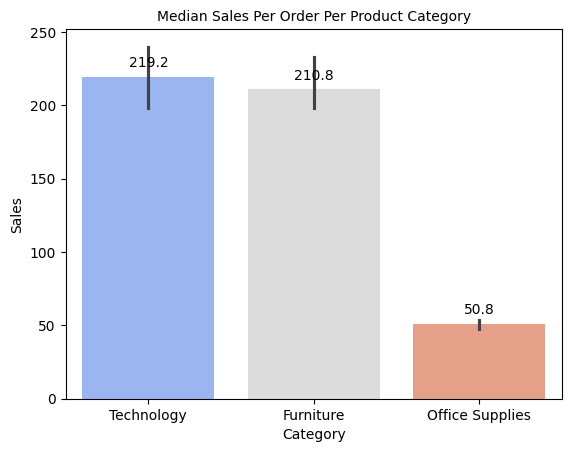

In [38]:
# Plotting the Barplot
ax = sns.barplot(order_category_sales, x = 'Category', y = 'Sales', estimator='median', palette = 'coolwarm')

# Annotate data labels
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.1f'),  # format height to 1 decimal
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position at center of bar
        ha = 'center',  # horizontal alignment
        va = 'bottom',  # vertical alignment
        fontsize=10,
        color='black',
        xytext=(0, 5),  # small shift up
        textcoords='offset points'
    )

# Setting title
plt.title("Median Sales Per Order Per Product Category", fontsize = 10)

# Display the plot
plt.show()

#Technology products make the highest median sales: $219

In [39]:
# Mean and Median Sales across Categories per order basis

order_category_sales.groupby('Category')['Sales'].agg(['mean', 'median'])  #sales of office-supplies items is most skewed.

# All category sales are right-skewed
# Furniture: mean is 2x median
# Office Supplies: mean is 4x median
# Technology: mean is 2.5x median

,mean,median
Category,,
Furniture,420.634805,210.830
Office Supplies,192.155808,50.784
Technology,541.550540,219.184


In [40]:
# Sales across Product Sub-Category per order basis

order_sub_category_sales = df.groupby(['Order ID', 'Sub-Category'])['Sales'].sum().reset_index() #total sales for each sub-category within an order.

<ipython-input-41-7fb7a2f5ebd8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(order_sub_category_sales, x = 'Sub-Category', y = 'Sales', estimator='median', palette = 'Set2',errorbar=None )


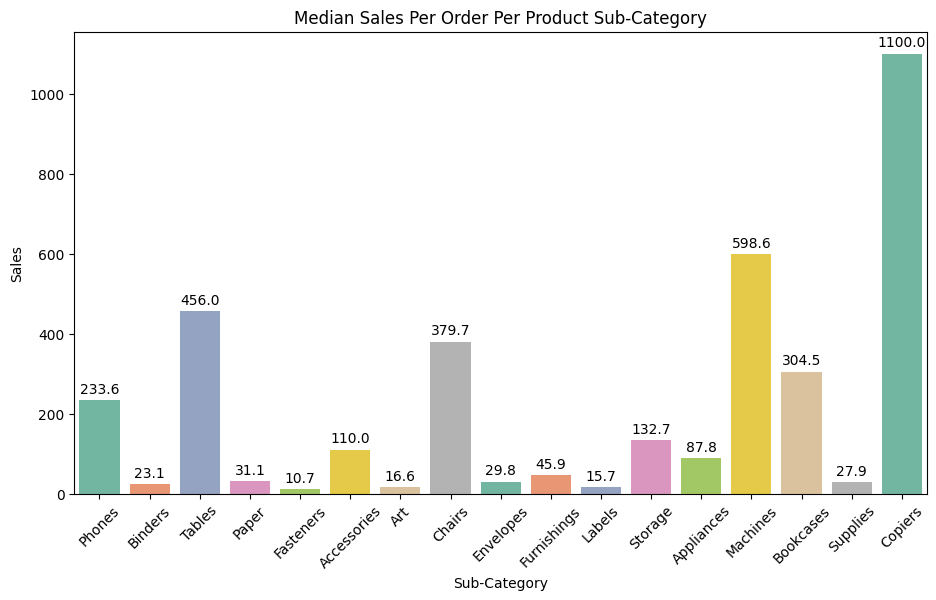

In [41]:
# Set the canvas size
plt.figure(figsize =(11,6))

# Plotting the Barplot
ax = sns.barplot(order_sub_category_sales, x = 'Sub-Category', y = 'Sales', estimator='median', palette = 'Set2',errorbar=None )

# Annotate data labels
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.1f'),  # format height to 1 decimal
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position at center of bar
        ha = 'center',  # horizontal alignment
        va = 'bottom',  # vertical alignment
        fontsize=10,
        color='black',
        xytext=(0, 3),  # small shift up
        textcoords='offset points'
    )

# Plot customization
plt.xticks(rotation=45)
plt.title("Median Sales Per Order Per Product Sub-Category", fontsize = 12)

# Display the plot
plt.show()

#Copiers make the highest average sales: $1100, this is not a outlier because copiers are expensive item compared to rest of product catalogue.

In [42]:
df_unique = df.groupby('Order ID').first().reset_index()  # equivalent of distinct count

<ipython-input-43-973b8ad2c59e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax  = sns.countplot(df[df['Sub-Category']=='Copiers'],y = 'Segment', width=0.5,  palette = 'Set2')


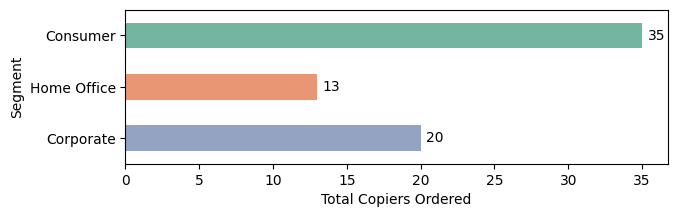

In [43]:
plt.figure(figsize =(7,2))

ax  = sns.countplot(df[df['Sub-Category']=='Copiers'],y = 'Segment', width=0.5,  palette = 'Set2')

for p in ax.patches:
    ax.annotate(
        format(p.get_width(), '.0f'),  # format height to 1 decimal
        (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2.),  # position at center of bar
        ha = 'left',  # horizontal alignment
        va = 'center',  # vertical alignment
        fontsize=10,
        color='black',
        xytext=(4, 0),  # small shift up
        textcoords='offset points'
    )
plt.xlabel("Total Copiers Ordered")

plt.show()

- Copier (sub-category bringing in most sales on average) is being most ordered by consumers.

###### **Profit vs Category / Sub-Category:** Compare Profit across product categories and subcategories

In [44]:
# Profit across Product Category per order basis

order_category_profit = df.groupby(['Order ID', 'Category'])['Profit'].sum().reset_index() #total profit for each category within an order.

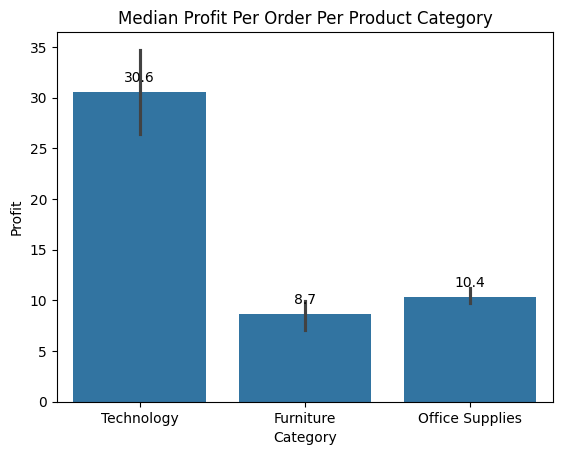

In [45]:
#Barplot

ax = sns.barplot(order_category_profit, x = 'Category', y = 'Profit', estimator='median')

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.1f'),  # format height to 1 decimal
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position at center of bar
        ha = 'center',  # horizontal alignment
        va = 'bottom',  # vertical alignment
        fontsize=10,
        color='black',
        xytext=(0, 5),  # small shift up
        textcoords='offset points'
    )
plt.title("Median Profit Per Order Per Product Category")

plt.show()

#Tech category is most profitable (3x than Office Supplies category) on average on per order basis.

In [46]:
# Mean and Median Profit across Categories per order basis

order_category_profit.groupby('Category')['Profit'].agg(['mean', 'median'])

,mean,median
Category,,
Furniture,10.459905,8.6834
Office Supplies,32.734046,10.3590
Technology,94.206573,30.5728


###### **Profit Margin Per Category / Sub-Category**

In [47]:
# Total Sales and Profit across Product Category per order basis

order_category = df.groupby(['Order ID', 'Category']).agg(Total_Sales=('Sales', 'sum'),Total_Profit=('Profit', 'sum')).reset_index()

In [48]:
# Profit Margin across Product Category per order basis

order_category['Profit Margin'] = (order_category['Total_Profit'] / order_category['Total_Sales']) * 100

In [49]:
# Mean and Median Profit Margin across Categories per order basis

order_category.groupby('Category')['Profit Margin'].agg(['mean', 'median'])

,mean,median
Category,,
Furniture,3.684714,10.000000
Office Supplies,14.230267,31.250000
Technology,16.070951,18.026282


**Comparision:**

In [50]:
# Sales, Profit and Profit Margin across Product Category comparision on per order basis

result_table  = pd.concat([
            order_category_sales.groupby('Category')['Sales'].agg(['median']).T.rename(index={'median': 'Sales'})
          , order_category_profit.groupby('Category')['Profit'].agg(['median']).T.rename(index={'median': 'Profit'})
          , order_category.groupby('Category')['Profit Margin'].agg(['median']).T.rename(index={'median': 'Profit Margin'})
           ], axis=0)

In [51]:
result_table

Category,Furniture,Office Supplies,Technology
Sales,210.8300,50.784,219.184000
Profit,8.6834,10.359,30.572800
Profit Margin,10.0000,31.250,18.026282


- Office Supplies has least average sales per order but has highest profit margin, while furniture has lowest profit margin despite roughly equal average sales as technology items per order, hence increase inventory of office supplies items but re-consider pricing or discount of furniture items.

###### **Profit vs Sales:** Identify if higher sales always lead to higher profits or if losses exist in high sales


In [52]:
# Unique records in the dataset

df['Order ID'].nunique()

5009

In [53]:
order_total_category = df.groupby(['Order ID','Category']).agg(Total_Sales=('Sales', 'sum'),Total_Profit=('Profit', 'sum')).reset_index()

<ipython-input-54-c85b402347d0>:11: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


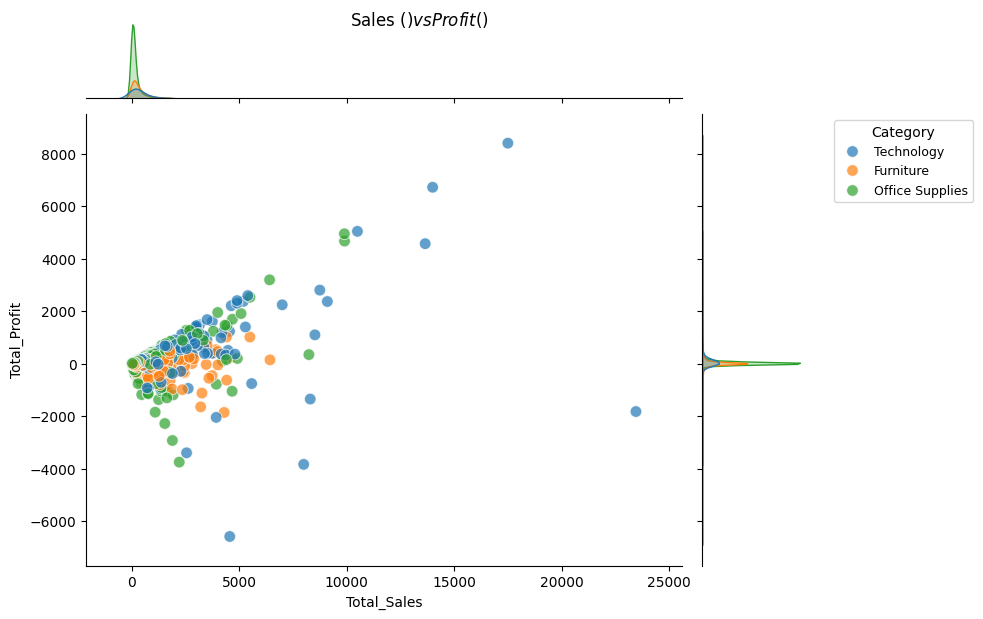

In [54]:
# Joint plot of Sales vs Profit across Product Category
g = sns.jointplot(data = order_total_category, x= 'Total_Sales', y='Total_Profit', kind='scatter', hue = 'Category', s=70, alpha=0.7,
    height=8 ,ratio=5)

# Customizing Plot
g.fig.suptitle('Sales ($) vs Profit ($)', fontsize=12, y=1)
g.ax_joint.legend(title='Category', bbox_to_anchor = (1.5,1), title_fontsize='10', fontsize='9',frameon=True)
g.fig.set_size_inches(8,6)

# Display plot
plt.tight_layout()
plt.show()

It is observed that:
-  High sales do lead to higher profits (between `$4000` and `$8000`) especially for certain technology products.
- However there are roughly equal number of high sale orders of tech products on which the company has incurred losses in range of `$2000` to `$4000`.
- Office Supply items have the highest negative profit margin on per order basis (evident by steepest slope).

In [55]:
# Total Sales and Profit across Product Category and Sub-Category per order basis

order_total_subcategory = df.groupby(['Order ID','Category','Sub-Category']).agg(Total_Sales=('Sales', 'sum'),Total_Profit=('Profit', 'sum')).reset_index()

<ipython-input-56-5566416e92c5>:12: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


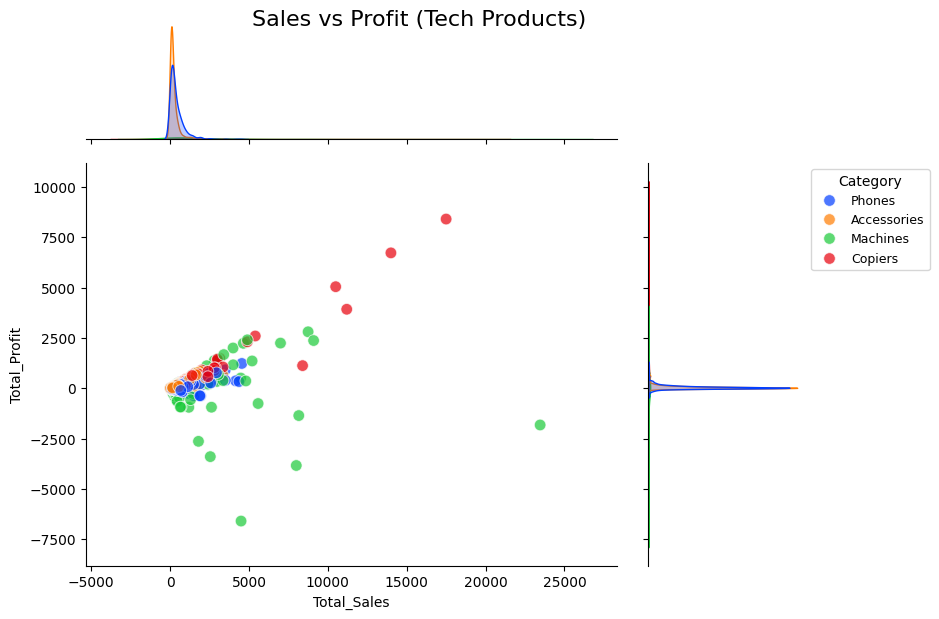

In [56]:
# Joint plot of Sales vs Profit for Technology Products

g = sns.jointplot(data = order_total_subcategory[order_total_subcategory['Category']=='Technology'], x= 'Total_Sales', y='Total_Profit',
    kind='scatter', hue = 'Sub-Category',palette = 'bright' ,s=70, alpha=0.7,height=8 ,ratio=3)

# Customizing Plot
g.fig.suptitle('Sales vs Profit (Tech Products)', fontsize=16, y=1)
g.ax_joint.legend(title='Category', bbox_to_anchor = (1.6,1), title_fontsize='10', fontsize='9',frameon=True)
g.fig.set_size_inches(8,6)

# Display plot
plt.tight_layout()
plt.show()

It is observed that:
- High sales on per order basis come from Copiers while Machines are denting the company beacuse of significant losses in range of `$2000` to `$4000` as discussed earlier. The superstore may consider phasing out this product offering from it's portfolio.

In [57]:
# Total Sales and Profit figures for each unique phone order

order_total_subcategory[order_total_subcategory['Sub-Category']=='Phones']

,Order ID,Category,Sub-Category,Total_Sales,Total_Profit
0,CA-2014-100006,Technology,Phones,377.970,109.6113
18,CA-2014-100867,Technology,Phones,321.552,20.0970
19,CA-2014-100881,Technology,Phones,302.376,22.6782
22,CA-2014-100895,Technology,Phones,239.970,67.1916
40,CA-2014-101602,Technology,Phones,40.680,-9.1530
...,...,...,...,...,...
9097,US-2017-163300,Technology,Phones,369.544,32.3351
9109,US-2017-164147,Technology,Phones,59.970,-11.9940
9125,US-2017-166324,Technology,Phones,122.382,-24.4764
9130,US-2017-166688,Technology,Phones,1123.128,70.1955


In [58]:
temp_df = (order_total_subcategory[order_total_subcategory['Sub-Category']=='Phones']).reset_index(drop=True)

In [59]:
# Count total rows
count_total = len(temp_df)

# Count rows where Total_Profit > 0
count_profit_positive = len(temp_df[temp_df['Total_Profit'] > 0])

# Count rows where Total_Profit < 0
count_profit_negative = len(temp_df[temp_df['Total_Profit'] < 0])

# Count rows where Total_Profit == 0
count_profit_zero = len(temp_df[temp_df['Total_Profit'] == 0])

# Display results
print(f"Phone orders:\n\n{(count_profit_positive/count_total)*100:.2f}% orders generated profit\n{(count_profit_negative/count_total)*100:.2f}% orders generated loss\n{(count_profit_zero/count_total)*100:.2f}% orders were break even")


Phone orders:

84.64% orders generated profit
15.23% orders generated loss
0.12% orders were break even


- Phone orders (within technology category) are majorly profitable hence the superstore can safely continue their sales.

######  **Profit vs Sales:** Analyze which customer segments contribute the most to profit

In [60]:
# Total Sales and Profit across Regions and Customer Segmnt on per order basis

order_region_segment = df.groupby(['Order ID', 'Region', 'Segment']).agg(Total_Sales=('Sales', 'sum'),Total_Profit=('Profit', 'sum')).reset_index()

In [61]:
# Adding Profit Margin column

order_region_segment['Profit Margin'] = (order_region_segment['Total_Profit'] / order_region_segment['Total_Sales']) * 100

In [62]:
# Segment Wise breakdown of Profit

order_region_segment.groupby('Segment')['Total_Profit'].agg(['mean', 'median', 'sum', 'count'])

,mean,median,sum,count
Segment,,,,
Consumer,51.863577,15.78100,134119.2092,2586
Corporate,60.752400,16.79105,91979.1340,1514
Home Office,66.335180,16.15800,60298.6785,909


 - Consumers bring in the most profit and is the largest demographic as well.
 - On per order basis, highest median profit comes from corporate orders which is expected under the assumption that they either buy bulk quantity or pricier items such as technology products.

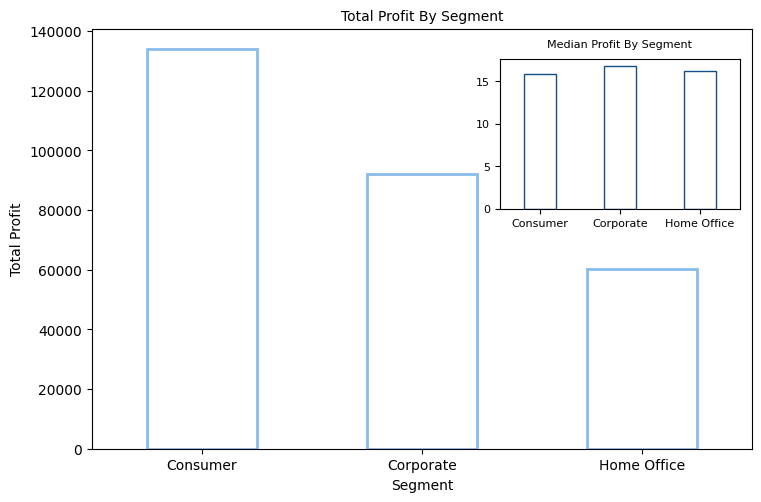

In [63]:
# Set Canvas Size
fig = plt.figure(figsize=(12, 6))

# Main Plot

# Add axis [left, bottom, width, height]
ax = fig.add_axes([0.2, 0.2, 0.55, 0.7])
#    fig.add_axes([left, bottom, width, height])

# Plot main graph
sns.barplot(data = order_region_segment, x = 'Segment', y = 'Total_Profit', estimator='sum',fill=False, errorbar= None,width=0.5, gap=2, linewidth=2, edgecolor = '#88bceb')

# Customize main plot
ax.set_xlabel('Segment')
ax.set_ylabel('Total Profit')
ax.set_title("Total Profit By Segment", fontdict={'fontsize':10, 'fontweight': 'normal'})

# Inset plot

# Add axis [left, bottom, width, height]
inset_ax = fig.add_axes([0.54, 0.6, 0.2, 0.25])

# Plot inset graph
sns.barplot(order_region_segment, x = 'Segment', y = 'Total_Profit', estimator='median',fill=False, errorbar= None, width=0.4, linewidth=1, edgecolor='#124f86')

# Customize inset plot
inset_ax.set_title("Median Profit By Segment",fontdict={'fontsize':8, 'fontweight': 'normal'}, y=1.02)
inset_ax.set_xlabel('')
inset_ax.set_ylabel('')
inset_ax.tick_params(axis='y', labelsize=8)
inset_ax.tick_params(axis='x', labelsize=8)

# Display plots
plt.show()

######  **Profit vs  Region / State:** Detect regional performance disparities and spot high/low-profit zones


In [64]:
# Per-order profitability by Region (e.g., "What’s the average profit per transaction/per order in the West region?")

order_region_segment.groupby('Region')['Total_Profit'].agg(['mean', 'median','sum']).sort_values(by='sum', ascending=False)

,mean,median,sum
Region,,,
West,67.298851,23.79930,108418.4489
East,65.326752,15.01200,91522.7800
South,56.872786,17.45965,46749.4303
Central,33.792649,6.97950,39706.3625


It is observed that:

 - West region outperforms others with approximately 15% more profit generated compared to East region which is the next most profitable region on per order basis.
 - Central Region is the most under-performing region with cumulative profit of approx `$40,000` which is roughly 3x lesser than West region.
 - Mean Profit as multiple of Median Profit by region:
   
   West: 2.8x  East: 4x  South: 3x  Central: 5x

   - This shows that there are high-value orders coming from Central region which pulls the mean order value much higher than the median: need to explore segment distribution in Central region to find if majorly corporate customers are ordering from there which are expected to make bulk quantity orders i.e. high-value orders.

In [65]:
# Per-item profitability by Region (e.g., "What’s the median profit of individual products sold in the East region?")

pd.pivot_table(df, values = 'Profit', index = 'Region', aggfunc = ['mean','median', 'sum']).sort_values(by=('sum', 'Profit'), ascending=False)

,mean,median,sum
,Profit,Profit,Profit
Region,,,
West,33.849032,11.1664,108418.4489
East,32.135808,8.1717,91522.7800
South,28.857673,9.0720,46749.4303
Central,17.092709,5.1840,39706.3625


######  **Profit Distribution by Region and Segment**

In [66]:
# Regional Per Order/Transaction Profit Distribution by Customer Segment

pd.pivot_table(order_region_segment, values = 'Total_Profit', index = 'Segment', columns = 'Region', aggfunc = ['mean','median', 'sum']).sort_values(by=('sum', 'Central'), ascending=False)

mean                                    median           \
Region         Central        East      South       West Central     East   
Segment                                                                     
Corporate    53.746845   54.429905  61.600094  71.005010  8.1489  16.6566   
Home Office  55.777634  105.154397  35.272018  54.918322  9.0055  16.0307   
Consumer     14.178888   57.771366  60.616155  69.637096  5.5588  13.3245   

                                      sum                                      
Region         South     West     Central        East       South        West  
Segment                                                                        
Corporate    14.6770  22.9320  18703.9020  23622.5789  15215.2232  34437.4299  
Home Office  16.2486  22.5563  12438.4124  26709.2168   4620.6343  16530.4150  
Consumer     18.5763  25.3302   8564.0481  41190.9843  26913.5728  57450.6040

It is observed that:

 - This table confirms that in Central Region, major profit is earned from Corporate hence the large disparity between median and mean profit per order.
 - It is also noted that in East, South and West regions, consumer segment brings in the biggest share of profit per transaction while Corporate Segment is biggest profit contributor in Central region.
 - However, most profit from Corporate segment has been earned from West region, this could be merely due to more Corporate orders coming in from there due to higher Corporate concentration in the West region compared to other regions. This needs to be explored.

In [67]:
# Order frequency across Region and Customer segment

pd.pivot_table(order_region_segment, values = 'Order ID', index = 'Region', columns = 'Segment', aggfunc = ['count'],margins=True,margins_name='Total')

count                            
Segment Consumer Corporate Home Office Total
Region                                      
Central      604       348         223  1175
East         713       434         254  1401
South        444       247         131   822
West         825       485         301  1611
Total       2586      1514         909  5009

It is observed that:

 - Most Corporate orders come from West region confirming why most profit from Corporate segment has been earned from West region.
 - Interestingly in Central region, most orders come from Consumer segment like other regions but Consumer segment has brought in least profit per order as seen in previous table. Is that because of larger discounts in Central region for consumers compared to other regions or high costs incurred by the store in Central region which is reducing the profit margin?

In [68]:
# Regional Per Order/Transaction Profit, Sales and Profit Margin Distribution by Customer Segment

order_region_segment.groupby(['Region','Segment']).agg({'Total_Profit':['sum'],'Total_Sales':['sum'], 'Profit Margin': ['mean', 'median']})

Total_Profit  Total_Sales Profit Margin           
                             sum          sum          mean     median
Region  Segment                                                       
Central Consumer       8564.0481  252031.4340    -11.469527   9.482093
        Corporate     18703.9020  157995.8128     -6.200657  13.616302
        Home Office   12438.4124   91212.6440     -5.311492  19.102069
East    Consumer      41190.9843  350908.1670     14.490999  24.444726
        Corporate     23622.5789  200409.3470     13.655964  25.000000
        Home Office   26709.2168  127463.7260     18.707687  27.734628
South   Consumer      26913.5728  195580.9710     16.962265  24.907868
        Corporate     15215.2232  121885.9325     13.593130  22.438181
        Home Office    4620.6343   74255.0015     16.329132  25.000000
West    Consumer      57450.6040  362880.7730     19.516160  25.388974
        Corporate     34437.4299  225855.2745     21.226204  26.000000
        Home Office   16530.4150  136721.7770     21.738307  28.000000

It is observed that:

 - Unlike other regions where median profit margin (per order basis) is stable across segments, in Central region: the profit margin for Consumer segment is nearly half of Home Office segment.

 - Is that because of larger discounts in Central region for consumers compared to other regions or high costs incurred by the store in Central region can be explored.

**What percentage of orders come from each segment and region?**

In [69]:
segment_count = order_region_segment[['Region','Segment']].value_counts().unstack()

In [70]:
segment_count

Segment,Consumer,Corporate,Home Office
Region,,,
Central,604,348,223
East,713,434,254
South,444,247,131
West,825,485,301


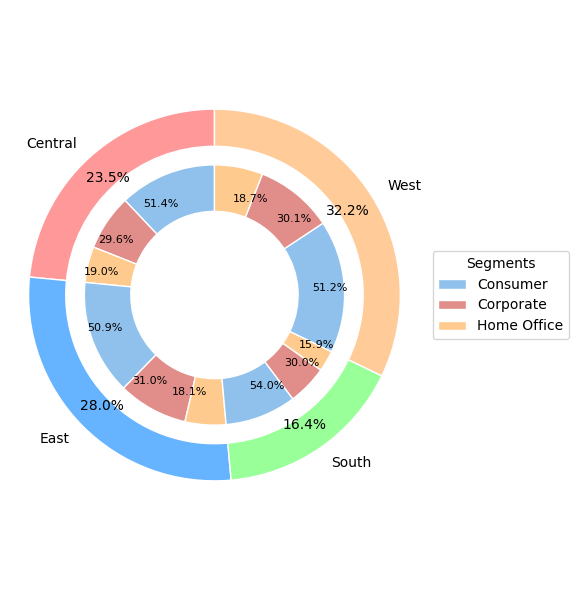

In [71]:
# Subplots

fig, ax = plt.subplots(figsize=(6, 6))

size = 0.3

# Calculate percentages for Segments (inner pie)

segment_percentages = (segment_count / segment_count.sum(axis=1).values.reshape(-1,1)) * 100

# Inner Pie (Segments per Region)

inner_pie = ax.pie(
    segment_count.values.flatten(),                                       # Flatten segment counts
    #labels=segment_count.columns.repeat(len(segment_count)),
    labels=[f'{p:.1f}%' for p in segment_percentages.values.flatten()],   # Show % labels
    labeldistance=0.75,
    wedgeprops=dict(width=0.25, edgecolor='white'),
    textprops={'fontsize': 8, 'color': 'black' },
    colors=['#90c1ec', '#e18d89', '#ffca8d'] * len(segment_count),
    radius=1-size,
    startangle=90,
)

# Add center legend for segments

ax.legend(
    inner_pie[0][:3],                                                     # First instance of each segment color
    segment_count.columns,
    title="Segments",
    loc='center',
    bbox_to_anchor=(1.2, 0.5)
)

# Outer Pie (Regions)

outer_pie = ax.pie(
    segment_count.sum(axis=1),
    labels = segment_count.index,
    autopct='%1.1f%%',
    pctdistance=0.85,
    startangle=90,
    wedgeprops=dict(width=0.2, edgecolor='white'),
    colors=['#FF9999', '#66B3FF', '#99FF99', '#FFCC99'],
    radius=1
)

# Equal aspect ratio ensures pie is drawn as a circle

ax.axis('equal')

# Title and Legend
'''
plt.title('Orders by Region and Segment', pad=20)
plt.legend(
    handles=outer_pie[0],
    labels = segment_count.index,
    title="Regions",
    loc="upper left",
    bbox_to_anchor=(1, 0.9)
) '''

# Display Plot

plt.tight_layout()
plt.show()

######  **Profit vs Ship Mode:** Check if certain shipping methods are more profitable or cost-intensive

In [72]:
# Cost, Profit and Sales by Ship Mode per unique order

per_transaction = df.groupby(['Order ID','Ship Mode']).agg(Total_Sales=('Sales', 'sum'),Total_Profit=('Profit', 'sum'),Total_Cost = ('Cost', 'sum') ).reset_index()

In [73]:
# Adding Profit Margin column

per_transaction['Profit Margin'] = (per_transaction['Total_Profit'] / per_transaction['Total_Sales']) * 100

In [74]:
#pd.crosstab(per_transaction['Ship Mode'], per_transaction['Total_Profit'], normalize = True)

# Total Cost, Profit and Sales distribution across types of Ship Mode on per order basis

ship_mode = pd.pivot_table(per_transaction, values =['Total_Cost','Total_Profit','Total_Sales'], index = 'Ship Mode', aggfunc = ['sum'])

In [75]:
# Adding Profit Margin column

ship_mode['Profit_Margin'] = (ship_mode[('sum', 'Total_Profit')]/ship_mode[('sum',  'Total_Sales')])*100

In [76]:
# Sorting by Profit Margin

ship_mode.sort_values(by=('Profit_Margin'), ascending=False)

sum                            Profit_Margin
                  Total_Cost Total_Profit   Total_Sales              
Ship Mode                                                            
First Class     3.024586e+05   48969.8399  3.514284e+05     13.934513
Second Class    4.017469e+05   57446.6354  4.591936e+05     12.510331
Same Day        1.124714e+05   15891.7589  1.283631e+05     12.380315
Standard Class  1.194127e+06  164088.7875  1.358216e+06     12.081202

In [77]:
# Sorting by Total Sales

ship_mode.sort_values(by=('sum',  'Total_Sales'), ascending=False)

sum                            Profit_Margin
                  Total_Cost Total_Profit   Total_Sales              
Ship Mode                                                            
Standard Class  1.194127e+06  164088.7875  1.358216e+06     12.081202
Second Class    4.017469e+05   57446.6354  4.591936e+05     12.510331
First Class     3.024586e+05   48969.8399  3.514284e+05     13.934513
Same Day        1.124714e+05   15891.7589  1.283631e+05     12.380315

It is observed that:

 - Standard Class yields the lowest profit margin despite highest total sales and profit. This could be because it is cost-intensive (may be eating into profits due to high logistics costs).

- Track the Region with most number of standard class orders -> Track the cities within that region with most number of standard class orders -> this will help superstore narrow down specific locations where it needs to negotiate better cost with the shipping partner to increase it's profit margin.

The low profit margin for Standard Class could be due to following reasons:

1. Standard Class handles a large volume of **low-margin orders** (e.g., bulk discounts, competitive pricing), the profit per transaction could be smaller even if total profit is high.

2. Price Sensitivity and Customer Behavior: Standard Class might attract price-sensitive customers who buy cheaper items, yielding less profit per sale/ low Average Order Value (AOV).

3. Shipping Costs: Standard Class might have lower fixed costs (e.g., no expedited logistics) but **higher variable costs per order** (e.g., longer delivery times → more handling, returns, or discounts). Due to lack of shipping cost data, this cannot be investigated.

In [78]:
# Average Order Value (AOV) or Average Sale Per Order:

per_transaction.groupby('Ship Mode')['Total_Sales'].agg(['mean','median'])

# The median AOV for standard class is approx $147 which is nearly same as that of First Class.

,mean,median
Ship Mode,,
First Class,446.541833,147.568
Same Day,486.223958,160.615
Second Class,476.341877,166.719
Standard Class,453.645873,147.676


In [79]:
# Comparing across shipping methods to see if Standard Class has lower profit per transaction:

per_transaction.groupby('Ship Mode')['Total_Profit'].agg(['mean','median'])

,mean,median
Ship Mode,,
First Class,62.223431,15.37200
Same Day,60.196056,18.09600
Second Class,59.591945,19.65465
Standard Class,54.805874,15.53850


Despite similar AOV and profit per transaction/order, Standard Class has lowest profit margin while First Class has highest profit margin.This could be due to:

 - **Price Premium for Speed**: First Class likely charges a higher shipping fee or Standard Class shipping could be free hence adding to direct profit.
 - **Fewer Discounts**: First Class orders might be less likely to use bulk discounts, preserving margin as opposed to Standard Class.
 - **Lower Operational Costs**: First Class may have lower operational cost (such as lower labor cost due to prioritized processing or fewer return/order cancellations).
 - **Customer Segment Differences**:
  - First Class buyers may purchase **higher-margin products** (even if AOV is similar).
  - Standard Class might be used for low-margin, high-volume items (e.g., essentials).


</font>

Recommended Steps:

 - **Analyze Product Mix by Shipping Method**:
 Check if Standard Class is tied to low-margin products. If yes, then bundle products to increase AOV.
 - **Promote First Class Shipping**: Since it yeilds the highest profit margin (approx 14%), hence highlight perks (faster delivery, fewer returns) to justify the price for first class shipping.
 - **Validate Hypothesis**:
  - "Standard Class’s low margin is driven by high promotional discounts."
    - Can be done by running A/B test or regression analysis with recent historical data if A/B test is not feasible. Be vary of correlation ≠ causation and cofounding variables when running regression analysis. If discounts are found to be eroding profit margins for standard shipping orders, then decision may be made to lower discounts.
 - **Analyze Cost Data**: If Standard Class orders have high logistic cost, then better terms may be negotiated with carriers such as lower bulk shipping rates.


</font>

######  **Profit vs Time (Month/Year)**: Seasonal profitability trends

In [80]:
# Define function to label quarters

def quarter(date):
    if (date.month >= 0) and (date.month <= 3):
      return 'Q1'

    elif (date.month >= 4) and (date.month <= 6):
      return 'Q2'

    elif (date.month >= 7) and (date.month <= 9):
      return 'Q3'

    else:
      return 'Q4'

In [81]:
# Add Quarter column

df['Quarter'] = df['Order Date'].apply(lambda x: quarter(x))

In [82]:
# Add Year column

df['Year'] = df['Order Date'].dt.year

In [83]:
# Add Month column

df['Month'] = df['Order Date'].dt.month

In [84]:
# Total Seasonal Profit and Sales across each Quarter

seasonal_profit_sales = df.groupby(['Year','Quarter'])[['Profit','Sales']].sum().reset_index()

In [85]:
# Adding Profit Margin column

seasonal_profit_sales['Profit Margin'] = (seasonal_profit_sales['Profit']/seasonal_profit_sales['Sales'])*100

In [86]:
# Adding label for x-tick

seasonal_profit_sales['Year-Quarter'] = seasonal_profit_sales['Year'].astype(str) + '-' + seasonal_profit_sales['Quarter']

In [87]:
# Sorting ascending by time

seasonal_profit_sales = seasonal_profit_sales.sort_values(['Year', 'Quarter'])

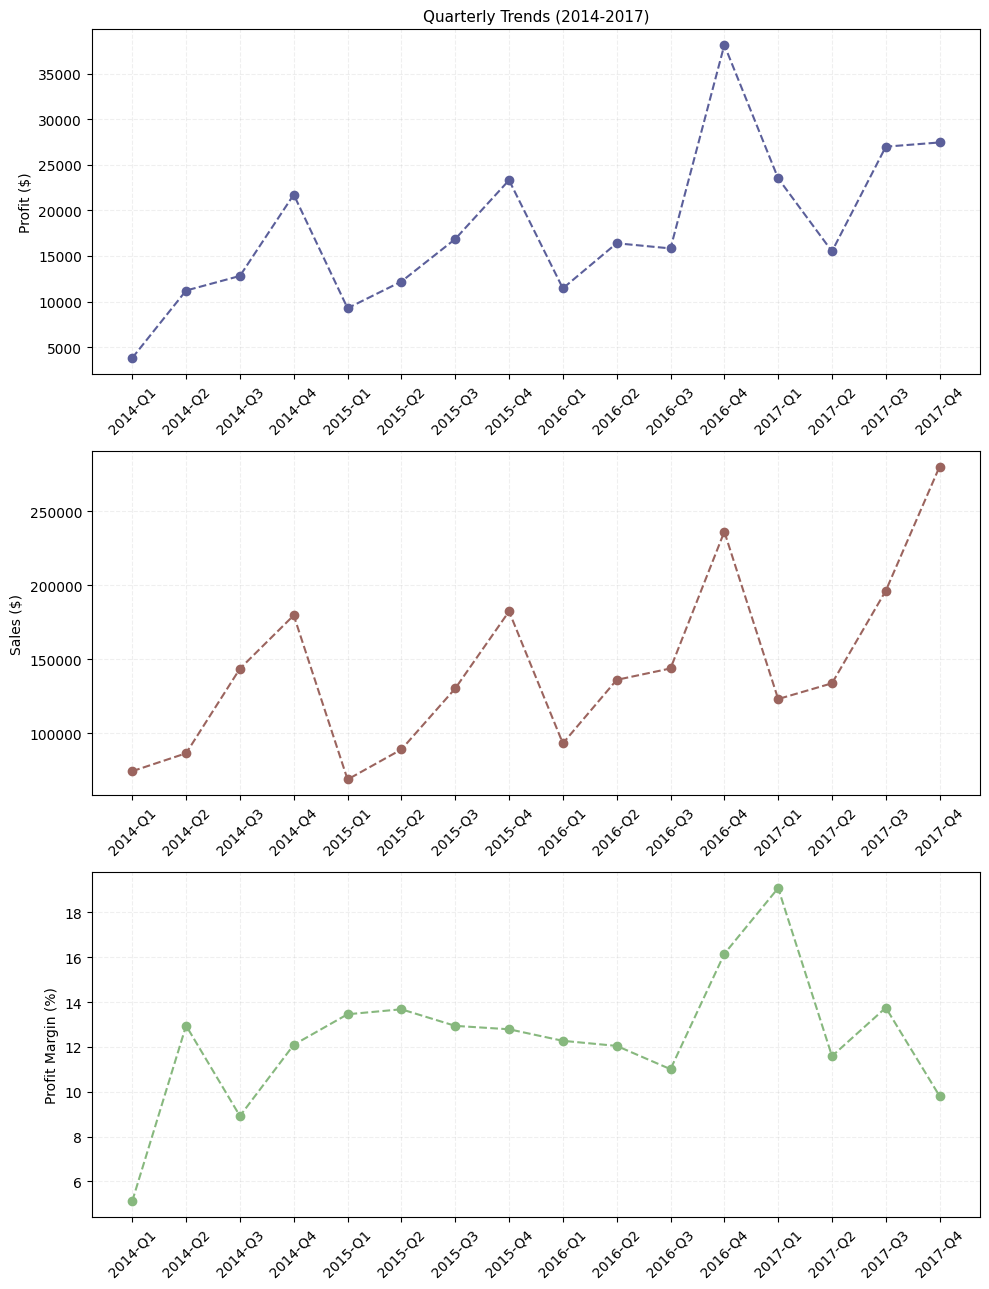

In [88]:
# Subplots
fig, axes = plt.subplots(nrows=3,ncols =1 ,figsize=(10,13))

#first plot: Profit
axes[0].plot(seasonal_profit_sales['Year-Quarter'], seasonal_profit_sales['Profit'], marker='o', linestyle='--', color= '#5b5f9a')
axes[0].set_ylabel('Profit ($)')
axes[0].set_title("Quarterly Trends (2014-2017)", fontsize=11)
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].grid(True, linestyle='--', alpha=0.2)

#second plot: Sales
axes[1].plot(seasonal_profit_sales['Year-Quarter'], seasonal_profit_sales['Sales'], marker='o', linestyle='--', color= '#9b645e')
axes[1].set_ylabel('Sales ($)')
#axes[1].set_title("Quarterly Sales Trends (2014-2017)", fontsize=11)
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].grid(True, linestyle='--', alpha=0.2)

#third plot: Profit Margin
axes[2].plot(seasonal_profit_sales['Year-Quarter'], seasonal_profit_sales['Profit Margin'], marker='o', linestyle='--', color= '#87b87e')
axes[2].set_ylabel('Profit Margin (%)')
#axes[2].set_title("Quarterly Profit Margin Trends (2014-2017)", fontsize=11)
axes[2].tick_params(axis='x', labelrotation=45)
axes[2].grid(True, linestyle='--', alpha=0.2)

# Display plot
plt.tight_layout()
plt.show()

**Quarterly Profit Trends (2014–2017)**

- Overall Growth: Profit shows a general increasing trend from 2014 to 2017, with significant spikes in late 2016 and late 2017.

- Volatility: There are frequent sharp drops after high peaks (e.g., after 2014 Q4, 2015 Q4, 2016 Q4).

- Seasonality: Q4 of each year tends to have a strong spike in profits, suggesting seasonal effects (possibly due to holiday sales).

- Recent Stability: In 2017 Q3 and Q4, profits stabilize at a relatively high level compared to earlier years.

**Quarterly Sales Trends (2014–2017)**
- Steady Growth: Sales show a strong and relatively consistent upward trend over the years.

- Sharp Drops: Noticeable sales drops occur in Q1 of each year, especially in 2015 and 2016.

- Peak in Q4: Like profits, sales peak dramatically in Q4 of each year — indicating strong end-of-year performance.

- Acceleration: The sales growth rate accelerates particularly in 2017.

**Quarterly Profit Margin Trends (2014–2017)**

- Initial Stability, Later Volatility: Profit margins are fairly stable around 12–14% from 2014 to early 2016 but become much more volatile afterward.

- High Peaks: A major peak occurs in 2017 Q1 (around 19%), suggesting exceptional efficiency/profitability for that quarter.

- Recent Decline: After peaking, profit margins decrease sharply towards the end of 2017 despite high sales.

- Decoupling: Sales and profits are growing, but margins are shrinking, indicating rising costs or inefficiencies.



**Actionable Recommendations**:
- Investigate Q4 Strategies: Leverage the success of Q4 campaigns throughout the year — analyze what drives the Q4 spikes (e.g., promotions, product launches, seasonal demand).

- Address Margin Compression: Since profit margins declined in late 2017 despite high sales, stakeholders should analyze cost structures — possibly renegotiating supplier contracts, optimizing operational costs, or increasing prices selectively.

- Smooth Out Seasonality: Explore strategies to boost Q1 sales and profits, which consistently dip — such as loyalty programs, off-season promotions, or new product introductions early in the year.

- Focus on Sustainable Growth: While sales are growing rapidly, ensuring that profit margins are maintained will be crucial. Focus should not only be on revenue growth but also on operational efficiency.

- Predict and Prepare for Volatility: Build contingency plans for quarters following strong Q4s to cushion typical profit and sales drop-offs (like in Q1).

- Deep Dive into 2017: Specially investigate why profit margins declined despite record sales — was it due to heavy discounting, rising input costs, or operational issues?

## Multivariate Analysis


######  **Profit Margin vs Time**

In [89]:
# Define function for Weighted Discount

def WeightedDiscountRate(group):
  return (group['Discount'] * group['PreDiscountSales']).sum() / group['PreDiscountSales'].sum()

In [90]:
# Weighted Discount Rate is a way of measuring the true economic impact of discounts by giving more importance to higher-priced items.

weighted_discounts = df.groupby('Order ID').apply(WeightedDiscountRate).reset_index(name='Weighted Discount Rate')

<ipython-input-90-e3957686719c>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_discounts = df.groupby('Order ID').apply(WeightedDiscountRate).reset_index(name='Weighted Discount Rate')


In [91]:
# Merging with original dataframe to add Weighted Discount column in the original data

df_wd = df.merge(weighted_discounts, on='Order ID')

In [92]:
# Dataframe with Unique Order IDs and product category within an order recorded within the same row

df_grouped  = df.groupby('Order ID').agg({
    'Order Date': 'first',
    'Ship Date': 'first',
    'Ship Mode': 'first',
    'Customer ID': 'first',
    'Customer Name': 'first',
    'Segment': 'first',
    'City': 'first',
    'State': 'first',
    'Postal Code': 'first',
    'Region': 'first',
    'Category': list,
    'Sales': 'sum',
    'Profit':'sum',
    'Cost':'sum',
    'Delay': 'first',
    'Quarter':'first',
    'Year':'first',
    'Month':'first',
    'PreDiscountSales':'sum'
  }).reset_index()

In [93]:
# Adding Profit Margin column

df_grouped['Profit Margin'] = (df_grouped['Profit']/df_grouped['Sales'])*100

In [94]:
# Adding label for x-tick

df_grouped['Year-Quarter'] = df_grouped['Year'].astype(str) + '-' + df_grouped['Quarter']

In [95]:
# Sort values by time

df_grouped = df_grouped.sort_values(['Year', 'Quarter'])

In [96]:
# Filtering 2017 data

df_grouped_2017 = df_grouped.query("Year== 2017").reset_index()

In [97]:
# Dropping index column

df_grouped_2017 = df_grouped_2017.drop(columns='index', axis=0)

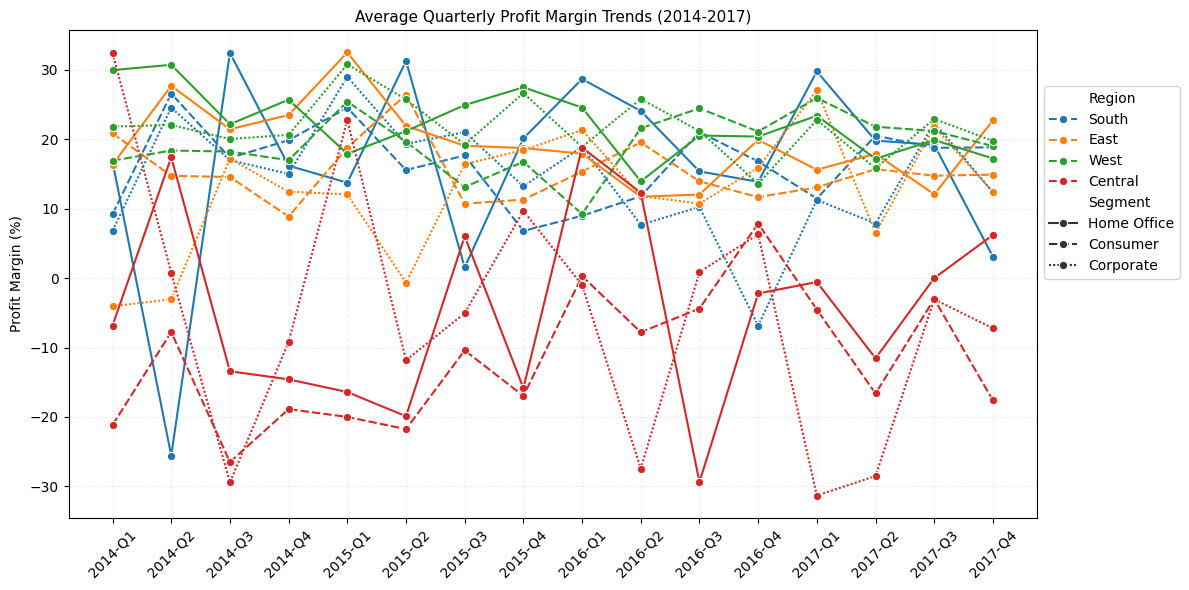

In [98]:
# Canvas Size
plt.figure(figsize=(12, 6))

# Plot graph
sns.lineplot(data = df_grouped, x= df_grouped['Year-Quarter'], y= df_grouped['Profit Margin'], hue='Region',marker='o', linestyle='--', color= '#87b87e',
            style = 'Segment',errorbar = None, estimator="mean")

# Customizing the plot
plt.xlabel('')
plt.ylabel('Profit Margin (%)')
plt.title("Average Quarterly Profit Margin Trends (2014-2017)", fontsize=11)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.2)


# Show the plot
plt.legend(bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

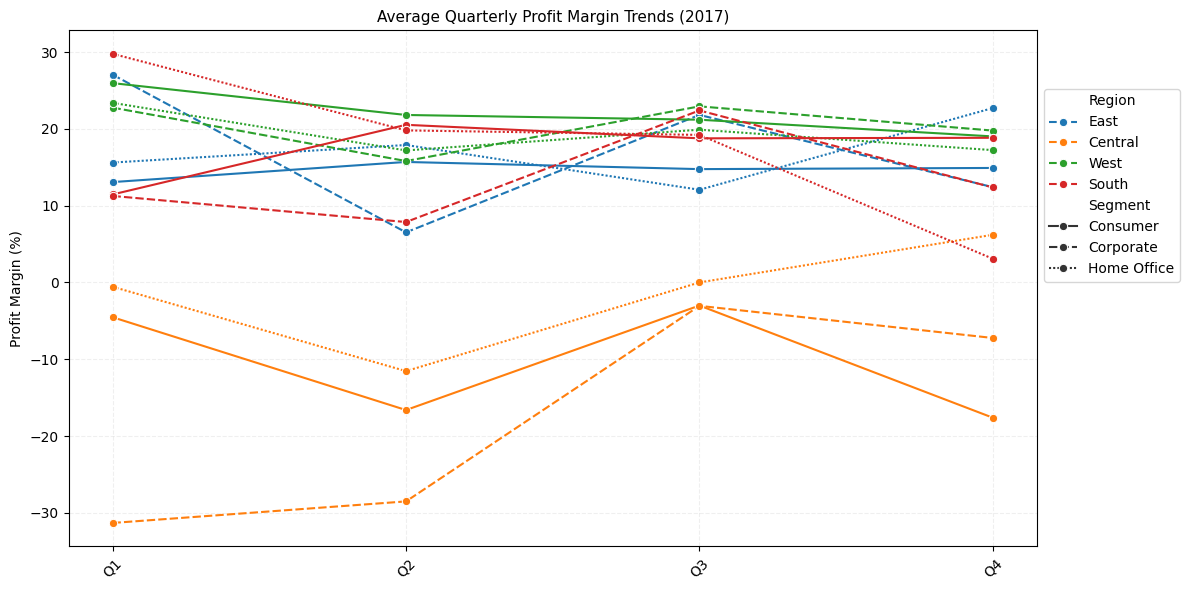

In [99]:
# Canvas Size
plt.figure(figsize=(12, 6))

# Plot graph
sns.lineplot(data = df_grouped_2017, x= df_grouped_2017['Quarter'], y= df_grouped_2017['Profit Margin'], hue='Region',marker='o', linestyle='--', color= '#87b87e',
            style = 'Segment',errorbar = None,  estimator="mean")

# Customizing the plot
plt.xlabel('')
plt.ylabel('Profit Margin (%)')
plt.title("Average Quarterly Profit Margin Trends (2017)", fontsize=11)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.2)


# Show the plot
plt.legend(bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

- The steepest drop in average profit margin from Q3 to Q4 of 2017 is observed in Consumer segment in Central region (-3% to -17.6%), and Home Office segment in South region (19% to 3%).
- The superstore may consider further investigating the driver(s) behind this poor performance in these specific demographics:
  - were there cost spikes from manufacturers or logistic partners that eat up major chunk of profit. Example: A hurricane in the South (e.g., Hurricane Harvey in Aug 2017 in Texas and Louisiana) could have disrupted logistics, increasing freight costs.
  - were heavy discounts run in last quarter of 2017 for these segments?
  - did Q4 sales in these demographics skew towards low-margin items?

In [100]:
# Profit Margin in each quarter of 2017 across regions and customer segments

df_grouped_2017.groupby(['Quarter', 'Region', 'Segment'])['Profit Margin'].median()

Quarter  Region   Segment    
Q1       Central  Consumer       26.750000
                  Corporate      10.000000
                  Home Office    26.187815
         East     Consumer       26.000000
                  Corporate      27.000000
                  Home Office    17.824870
         South    Consumer       22.000000
                  Corporate      26.681186
                  Home Office    32.707593
         West     Consumer       31.948078
                  Corporate      25.206515
                  Home Office    28.000000
Q2       Central  Consumer       11.250000
                  Corporate      -2.271968
                  Home Office    12.500000
         East     Consumer       28.000000
                  Corporate       9.873950
                  Home Office    20.341298
         South    Consumer       27.194683
                  Corporate      14.125000
                  Home Office    25.862400
         West     Consumer       28.000000
                  Corporate      25.000660
                  Home Office    28.570231
Q3       Central  Consumer       13.250000
                  Corporate      23.750000
                  Home Office    16.247222
         East     Consumer       26.000000
                  Corporate      27.750000
                  Home Office    29.402678
         South    Consumer       26.692396
                  Corporate      20.053029
                  Home Office    20.500000
         West     Consumer       26.540403
                  Corporate      26.000000
                  Home Office    25.000000
Q4       Central  Consumer        6.995440
                  Corporate      11.250000
                  Home Office    28.182886
         East     Consumer       23.468890
                  Corporate      21.551025
                  Home Office    27.000000
         South    Consumer       23.796359
                  Corporate      24.000000
                  Home Office    12.500000
         West     Consumer       27.864475
                  Corporate      27.739967
                  Home Office    22.810904
Name: Profit Margin, dtype: float64

In [101]:
df_grouped_2017['Profit Margin'].describe()

,Profit Margin
count,1687.000000
mean,11.010797
std,43.309045
min,-275.000000
25%,5.750121
50%,24.973299
75%,34.185256
max,50.000000


In [102]:
# Ungrouped 2017 data

df_2017 = df.query("Year== 2017").reset_index()

In [103]:
# Adding Gross Sales column

df_2017['PreDiscountSales'] = df_2017['Sales'] / (1 - df_2017['Discount'])

In [104]:
# 2017 data on per order basis (including Weighted Discount column)

df_2017_weighted_discount = df_2017.groupby('Order ID').apply(
        lambda x: pd.Series({
        'Sales': x['Sales'].sum(),
        'PreDiscountSales': x['PreDiscountSales'].sum(),
        'Profit': x['Profit'].sum(),
        'WeightedDiscountRate': (x['Discount'] * x['PreDiscountSales']).sum() / x['PreDiscountSales'].sum(),
        'Region' :x['Region'].iloc[0],
        'Segment': x['Segment'].iloc[0],
        'Quarter': x['Quarter'].iloc[0]
    })
).reset_index()

<ipython-input-104-f677c86b7a36>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_2017_weighted_discount = df_2017.groupby('Order ID').apply(


In [105]:
# Adding Profit Margin column

df_2017_weighted_discount['Profit Margin'] = (df_2017_weighted_discount['Profit']/df_2017_weighted_discount['Sales'])*100

In [106]:
# Correlation analysis of profit margin and weighted discount rates in 2017 (all regions):

corr_matrix = df_2017_weighted_discount.corr(numeric_only = True)

corr_matrix

# high negative (-0.86) correlation exist between profit margin and weighted discount rate in 2017.

,Sales,PreDiscountSales,Profit,WeightedDiscountRate,Profit Margin
Sales,1.000000,0.938861,0.560200,-0.040083,0.019414
PreDiscountSales,0.938861,1.000000,0.281420,0.094762,-0.098689
Profit,0.560200,0.281420,1.000000,-0.283939,0.284056
WeightedDiscountRate,-0.040083,0.094762,-0.283939,1.000000,-0.858982
Profit Margin,0.019414,-0.098689,0.284056,-0.858982,1.000000


In [107]:
# 2017 Q4 data of South and Central regions

df_2017_weighted_discount_south_central_Q4 = df_2017_weighted_discount[(df_2017_weighted_discount['Region'].isin(
    ['South','Central'])) & (df_2017_weighted_discount['Quarter'] == 'Q4')]

In [108]:
# Correlation analysis of profit margin and weighted discount rates in 2017 (Q4), only South and Central regions:

corr_matrix_2 = df_2017_weighted_discount_south_central_Q4.corr(numeric_only = True)
corr_matrix_2

,Sales,PreDiscountSales,Profit,WeightedDiscountRate,Profit Margin
Sales,1.000000,0.885353,-0.400369,0.007709,-0.029322
PreDiscountSales,0.885353,1.000000,-0.751240,0.207836,-0.185698
Profit,-0.400369,-0.751240,1.000000,-0.422257,0.353470
WeightedDiscountRate,0.007709,0.207836,-0.422257,1.000000,-0.880378
Profit Margin,-0.029322,-0.185698,0.353470,-0.880378,1.000000


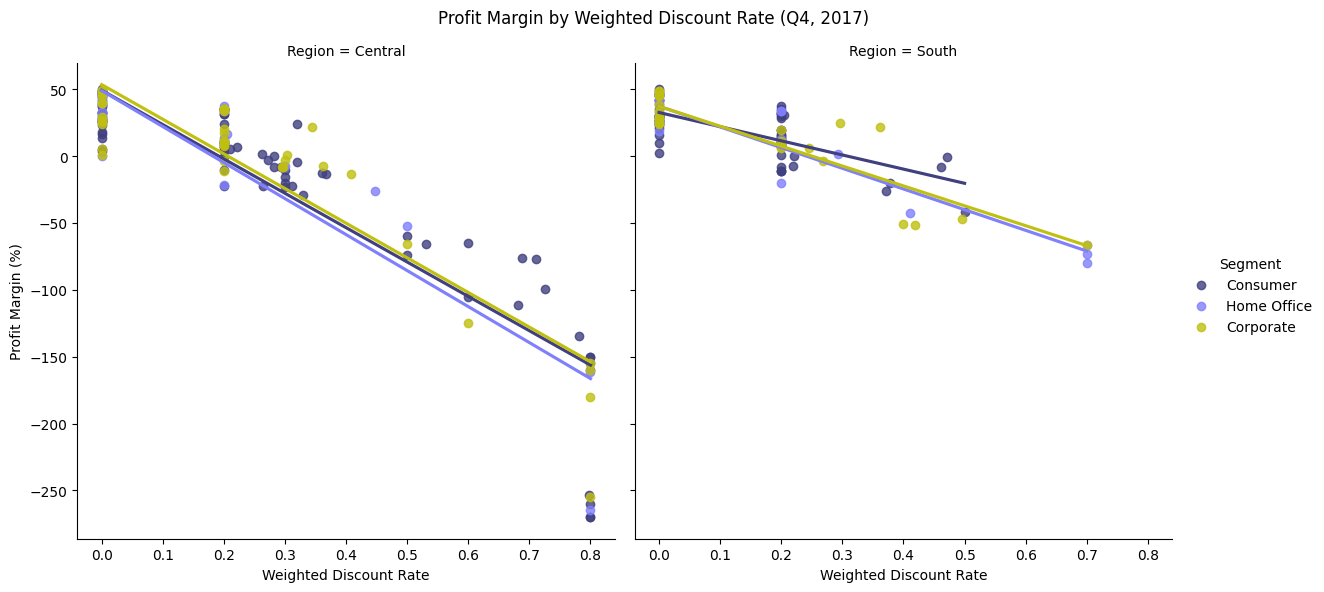

In [109]:
# Profit Margin vs Weighted Discount Rate (South & Central Regions, Q4 2017)

# Plot Graph
g = sns.lmplot(                                 # combines regplot() and FacetGrid
    data= df_2017_weighted_discount_south_central_Q4,
    x='WeightedDiscountRate',
    y='Profit Margin',
    hue = 'Segment',
    col='Region',
    height=6,
    ci= None,
    palette = 'gist_stern'
)

# Customizing Plot
g.fig.suptitle("Profit Margin by Weighted Discount Rate (Q4, 2017)", fontsize=12)
g.fig.subplots_adjust(top=0.89)
g.set_axis_labels("Weighted Discount Rate", "Profit Margin (%)")

# Display Plot
plt.show()

It can be concluded that:

- The profit margin drop in Central region has been due to high discounts (60%-80%) given to Consumer segment in the last quarter of 2017 as can be observed in the plot and high negative correlation of -0.88.
- In South region, the discounts given to Home Office segment  have ranged between 0-20% with only a couple of orders that have been discounted more than 50%. This indicates that the profit margin has been impacted by other factors such as costs/sale of low margin products.  

######  **Time (Month/Year) + Category vs Profit**: Analyze time-based trends in category-level performance

In [110]:
# Profit and Sales across each month by Product Category

month_category = df.groupby(['Year','Month', 'Category'])[['Profit','Sales']].sum().reset_index()

In [111]:
# Filtering data for 2016 and 2017

month_category = month_category[month_category['Year'].between(2016, 2017)].reset_index()
month_category = month_category.drop(columns = 'index', axis=0)

In [112]:
# Label for xtick

month_category['Month-Year'] =  month_category['Month'].astype(str) + '-' + month_category['Year'].astype(str)

In [113]:
# Sort values by time

month_category = month_category.sort_values(['Year', 'Month'])

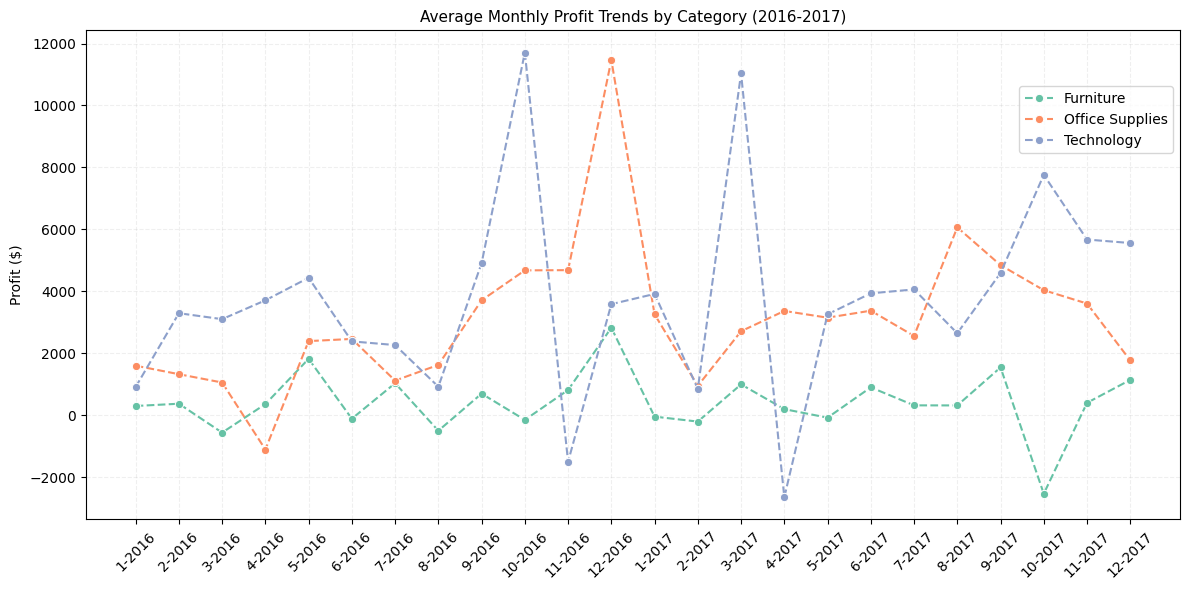

In [114]:
# Set Canvas size
plt.figure(figsize=(12, 6))

# Plot graph
sns.lineplot(data = month_category, x= month_category['Month-Year'], y= month_category['Profit'], hue='Category',marker='o', linestyle='--',
            errorbar = None,  estimator="mean", palette = 'Set2')

# Customizing the plot
plt.xlabel('')
plt.ylabel('Profit ($)')
plt.title("Average Monthly Profit Trends by Category (2016-2017)", fontsize=11)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.2)

# Show the plot
plt.legend(bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

It is observed that:

- Over the last two years, furniture items have comparatively yielded lesser profits  ranging between `$-2500` and `$2800`.
- Although technology is a high profit yielding category but is also the most volatile, where some months especially Oct 2016 and Mar 2017 had record profit of `$11,700` and `$11,000` respectively. Nov 2016 and Apr 2017 however, dented the superstore bearing losses of `$1500` and `$2600` respectively.
- Office Supplies profits have also been generally on the rise, with Dec 2016 bringing in highest profit of approx `$11,460`.
- Over the last couple of months, the profits for technology and office supply items have dropped while that of furniture has risen.   


</font>

In [115]:
# Profit distribution across Product Category

month_category.groupby('Category')['Profit'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Furniture,24.0,415.764350,994.768631,-2526.9203,-81.228800,344.7289,928.960000,2828.6715
Office Supplies,24.0,3116.577121,2372.883810,-1100.4821,1623.011275,2934.8442,3795.725050,11466.6686
Technology,24.0,3769.093692,3237.074444,-2639.7739,2359.369000,3651.7164,4674.349425,11707.7475


In [116]:
# Monthly Profit across Product Categories for 2016 and 2017

X = month_category.groupby(['Month-Year', 'Category'])['Profit'].mean()

In [117]:
print(X)

Month-Year  Category       
1-2016      Furniture           303.9607
            Office Supplies    1604.4712
            Technology          916.3914
1-2017      Furniture           -39.4402
            Office Supplies    3260.4467
                                 ...    
9-2016      Office Supplies    3714.0417
            Technology         4912.0134
9-2017      Furniture          1548.6837
            Office Supplies    4847.7438
            Technology         4595.1281
Name: Profit, Length: 72, dtype: float64


In [118]:
# Total Cost, Profit and Sales across Sub-categories of Office Supply items in Q4, 2017

month_subcategory = df[(df['Year'] == 2017) & (df['Quarter'] == 'Q4') & (df['Category'] == 'Office Supplies')].groupby(['Month', 'Sub-Category'])[['Profit','Sales','Cost']].sum().reset_index().sort_values('Month')

In [119]:
# Adding Profit Margin column

month_subcategory['Profit Margin'] = (month_subcategory['Profit']/month_subcategory['Sales'])*100

<ipython-input-120-32d6b5c7dbce>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(month_subcategory, x = 'Sub-Category', y = 'Profit Margin', estimator='mean',errorbar= None, ax=axes[0], palette = 'Set2')
<ipython-input-120-32d6b5c7dbce>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(month_subcategory, x = 'Sub-Category', y = 'Sales', estimator='mean',errorbar= None, ax=axes[1],palette = 'Set2')
<ipython-input-120-32d6b5c7dbce>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.barplot(month_subcategory, x = 'Sub-Category', y = '

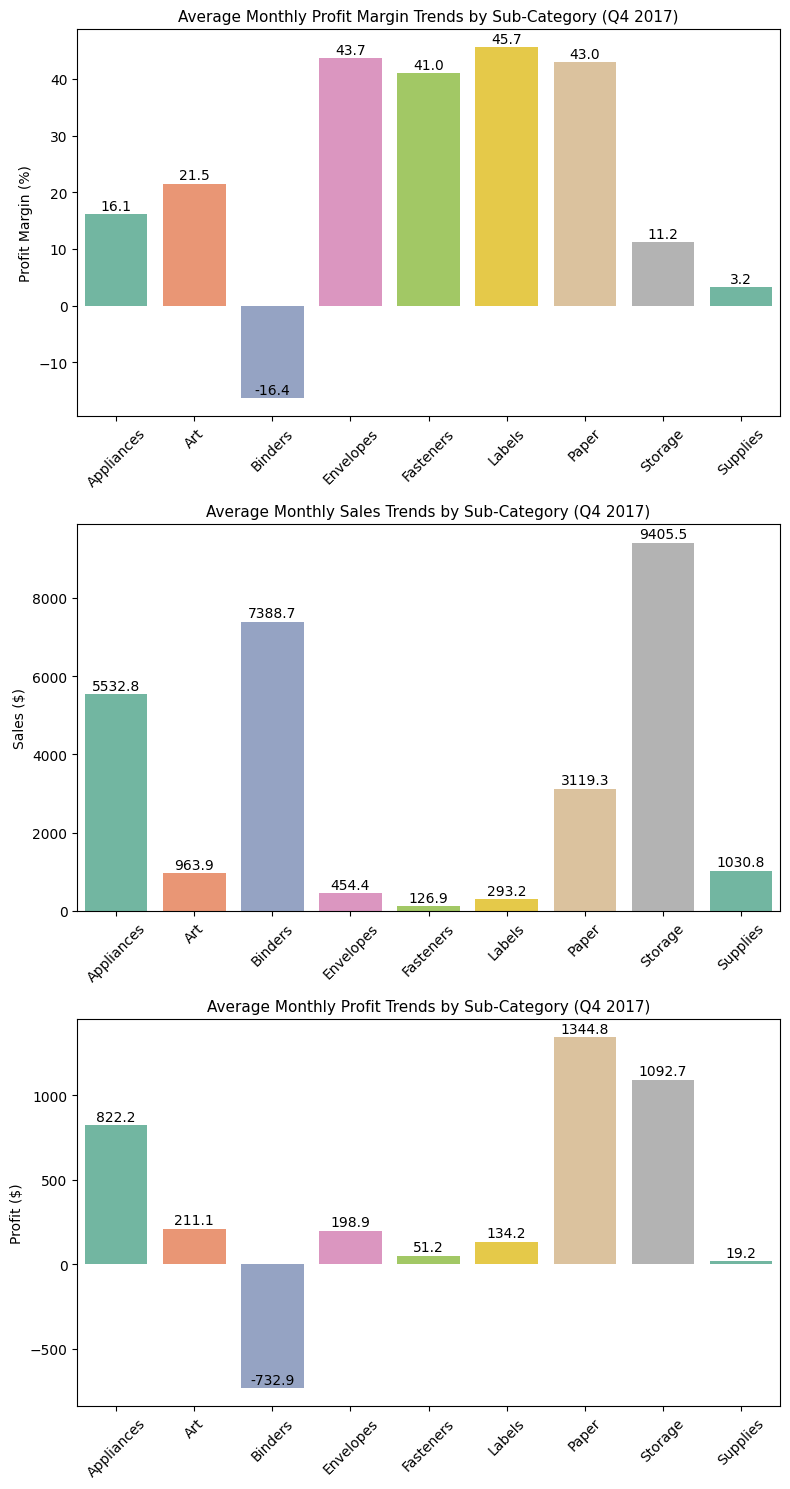

In [120]:
# Average Profit Margin by Sub-Category of Office Supply items for Q4 of 2017

#Barplot
fig, axes = plt.subplots(nrows=3,ncols =1 ,figsize=(8,15))

#first plot: profit margin

# plot graph
ax1 = sns.barplot(month_subcategory, x = 'Sub-Category', y = 'Profit Margin', estimator='mean',errorbar= None, ax=axes[0], palette = 'Set2')

# annotate data labels
for p in ax1.patches:
    ax1.annotate(
        format(p.get_height(), '.1f'),  # format height to 1 decimal
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position at center of bar
        ha = 'center',  # horizontal alignment
        va = 'bottom',  # vertical alignment
        fontsize=10,
        color='black',
        xytext=(0, 1),  # small shift up
        textcoords='offset points'
    )

# Customize plot
axes[0].set_xlabel('')
axes[0].set_ylabel('Profit Margin (%)')
axes[0].set_title("Average Monthly Profit Margin Trends by Sub-Category (Q4 2017)", fontsize=11)
axes[0].tick_params(axis='x', labelrotation=45)

#second plot: sales
ax2 = sns.barplot(month_subcategory, x = 'Sub-Category', y = 'Sales', estimator='mean',errorbar= None, ax=axes[1],palette = 'Set2')

for p in ax2.patches:
    ax2.annotate(
        format(p.get_height(), '.1f'),  # format height to 1 decimal
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position at center of bar
        ha = 'center',  # horizontal alignment
        va = 'bottom',  # vertical alignment
        fontsize=10,
        color='black',
        xytext=(0, 1),  # small shift up
        textcoords='offset points'
    )
axes[1].set_xlabel('')
axes[1].set_ylabel('Sales ($)')
axes[1].set_title("Average Monthly Sales Trends by Sub-Category (Q4 2017)", fontsize=11)
axes[1].tick_params(axis='x', labelrotation=45)

#third plot: profit
ax3 = sns.barplot(month_subcategory, x = 'Sub-Category', y = 'Profit', estimator='mean',errorbar= None, ax=axes[2],palette = 'Set2')

for p in ax3.patches:
    ax3.annotate(
        format(p.get_height(), '.1f'),  # format height to 1 decimal
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position at center of bar
        ha = 'center',  # horizontal alignment
        va = 'bottom',  # vertical alignment
        fontsize=10,
        color='black',
        xytext=(0, 1),  # small shift up
        textcoords='offset points'
    )
axes[2].set_xlabel('')
axes[2].set_ylabel('Profit ($)')
axes[2].set_title("Average Monthly Profit Trends by Sub-Category (Q4 2017)", fontsize=11)
axes[2].tick_params(axis='x', labelrotation=45)

# Display plots
plt.tight_layout()
plt.show()

- The drop in Office Supplies profit margin in Dec 2017 is specifically due to Binders which despite second highest sales in Q4 has caused superstore to loose approx `$700`.
- Considering Binders is low profit margin sub-category, the superstore needs to see whether it was caused by internal decisions such as heavy discounting to clear year-end inventory (in which case the low profit margin would have been anticipated) or externals factors influenced it such as Hurricane Harvey in Aug 2017 or costs spike by shipping carriers.

######**Category + Discount vs Profit**: Analyze how discounts affect profitability across categories

In [121]:
# Adding Profit Margin column

df_wd['Profit Margin'] = (df_wd['Profit']/df_wd['Sales'])*100

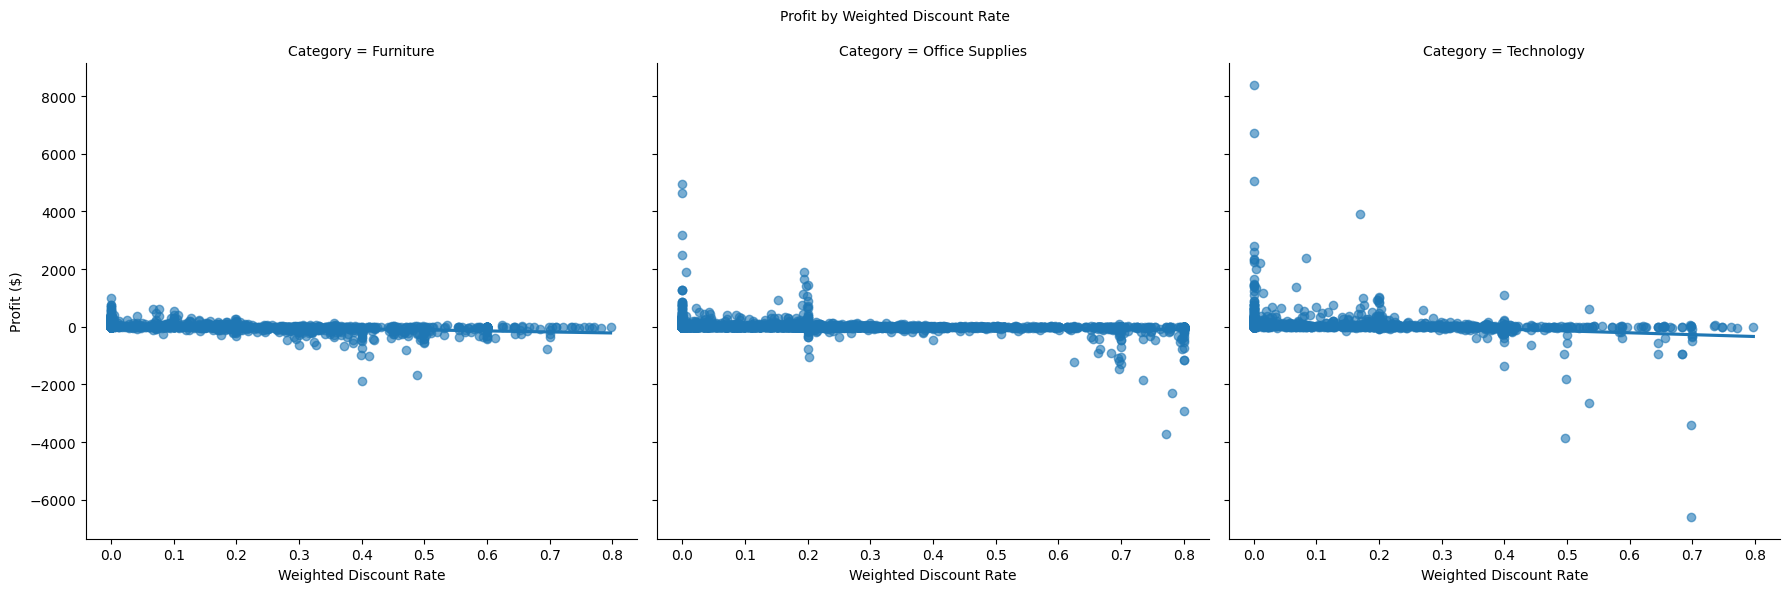

In [122]:
# Profit vs Weighted Discount Rate across Category

# plot graph
g = sns.lmplot(
    data= df_wd ,
    x='Weighted Discount Rate',
    y='Profit',
    col='Category',
    height=6,
    ci= None,
    palette = 'gist_stern',
    scatter_kws={'alpha': 0.6}
)

# customize plot
g.fig.suptitle("Profit by Weighted Discount Rate", fontsize=10)
g.fig.subplots_adjust(top=0.89)
g.set_axis_labels("Weighted Discount Rate", "Profit ($)")

# display plot
plt.show()

 - Technology is most sensitive to discounts, while furniture and office supplies appear less affected overall.
 - Technology category displays a noticeable negative trend in its regression line.  Higher discounts in this category appear to have a more direct and negative impact on profitability compared to furniture and office supplies because technology products have higher COGS hence thinner profit margins.
 - Technology has higher price elasticity of demand (a larger change in quantity demanded for a given change in price): hence although higher discounts trigger larger sale spikes but erodes the profit due to thin profit margins.
 - Due to rapid tech innovation and new models being released, the seller is compelled to offer higher discounts to prevent inventory write-offs on old models. Furniture items are bought primarily for convenience/quality over price hence last longer reducing pressure to discount for clearance.
 - Tech consumers are price-sensitive due to online price comparasions and delay purchase in favor of significant discounts which slash profits as time passes. The outliers at high discount portrays such bargain hunters.

**Recommendation:**
 - Different discounting strategies is necessary for different product categories to optimize profitability.
 - For Technology products:
  - Cap discounts at 10–15% and bundle with services (e.g., warranties).
  - Use time-bound promotions (e.g., "48-hour flash sale") to limit margin erosion.

 - For Furniture and Office Supplies:
  - Leverage discounts to drive volume (high margins can absorb it).

######**Segment + Ship Mode vs Sales/Profit**: Understand how different segments use shipping methods and their associated performance.

In [123]:
a = (per_transaction.merge(order_region_segment, on='Order ID')).drop(columns = ['Total_Sales_x', 'Total_Profit_x', 'Total_Cost','Profit Margin_x', 'Total_Sales_y','Total_Profit_y', 'Profit Margin_y'], axis=1)

In [124]:
merged_data = a.merge(df.groupby('Order ID').agg(Sales=('Sales', 'sum'),Profit=('Profit', 'sum'),Cost = ('Cost', 'sum') ).reset_index(), on='Order ID')

In [125]:
profit_by_segment_shipmode = merged_data.pivot_table(index='Segment', columns='Ship Mode', values='Profit', aggfunc = 'mean')

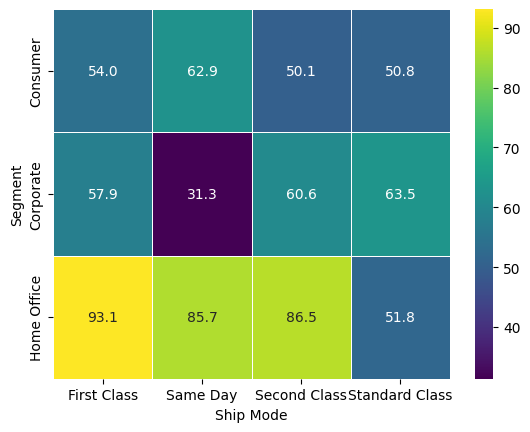

In [126]:
# Mean Profit Per Order/Transaction across Segments and Ship mode

plt.figure(dpi=100)

sns.heatmap(profit_by_segment_shipmode, linewidth=0.6, annot= True, cmap = 'viridis',fmt=".1f")

plt.show()

- In home office segment, significantly large profit is earned by first class shipping and significantly low by standard shipping.
- In corporate segment, same day shipping yeilds significantly lower profits while other ship modes yield comparable profits.
- In consumer segment, second class and standard class shipping yields lowest mean profit  while same day shipping yields relatively higher profit.

######**Region + Ship Mode vs Profit**: Analyze if some shipping modes are more efficient/profitable in certain regions


In [127]:
profit_by_region_shipmode = merged_data.pivot_table(index='Region', columns='Ship Mode', values='Profit', aggfunc = 'mean')

In [128]:
# Frequency of orders using each ship mode type across regions

merged_data.pivot_table(index='Region', columns='Ship Mode', values='Order ID', aggfunc = 'count')

Ship Mode,First Class,Same Day,Second Class,Standard Class
Region,,,,
Central,174,62,224,715
East,233,74,266,828
South,124,39,164,495
West,256,89,310,956


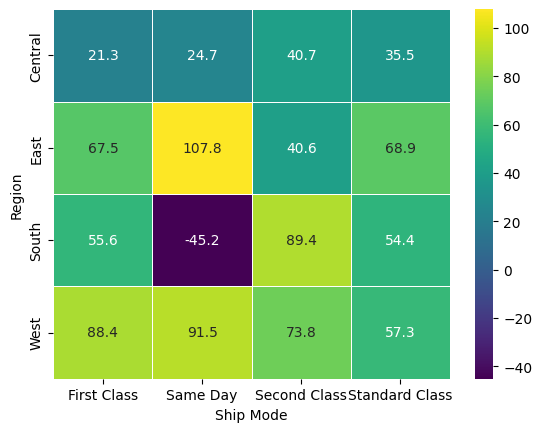

In [129]:
# Mean Profit Per Order/Transaction across Regions and Ship mode

plt.figure(dpi=100)

sns.heatmap(profit_by_region_shipmode, linewidth=0.6, annot= True, cmap = 'viridis',fmt=".1f")

plt.show()

- In West region, same day shipping yields significantly high profit while standard shipping brings in lowest mean profit per transaction.
- In South region, same day shipping has caused significant loss, on average the superstore loses `$45` per order that is shipped same day. Second class shipping is highest profit yielding in the region.
- In East region, same day shipping earns the highest average profit across board i.e. approx `$108` per transaction while second class shipping yields lower profits.
- In Central region, the profits are generally on the lower side, with first class and same day shipping yielding lowest average profits per order across the board.  

######**Sub-Category + Region vs Profit (or Profit Margin)** : Find which sub-categories are strong in each region


In [130]:
# Sales, Profit and Cost across each Region and Product Sub-Category

subcategory_region = df.groupby(['Region','Sub-Category'])[['Profit','Sales','Cost']].sum().reset_index()

In [131]:
# Adding profit margin column

subcategory_region['Profit Margin'] = (subcategory_region['Profit'] / subcategory_region['Sales']) * 100

In [132]:
# Sort values by Profit Margin within each Region

subcategory_region = subcategory_region.sort_values(by = ['Region','Profit Margin'], ascending=[True, False], axis=0)

In [133]:
#Top 3 performing sub-categories in each region

subcategory_region.groupby('Region').head(3).sort_values(by = ['Region','Profit Margin'], ascending=[True, False], axis=0)

,Region,Sub-Category,Profit,Sales,Cost,Profit Margin
10,Central,Labels,1073.0794,2451.472,1378.3926,43.772860
6,Central,Copiers,15608.8413,37259.570,21650.7287,41.892167
12,Central,Paper,6971.9005,17491.902,10520.0015,39.857875
29,East,Paper,9015.3710,20172.602,11157.2310,44.691166
27,East,Labels,1129.2800,2602.934,1473.6540,43.384888
24,East,Envelopes,1812.4090,4375.874,2563.4650,41.418217
44,South,Labels,1040.7723,2353.180,1312.4077,44.228334
41,South,Envelopes,1465.4770,3345.556,1880.0790,43.803691
46,South,Paper,5947.0614,14150.984,8203.9226,42.025780
58,West,Envelopes,1908.7624,4118.100,2209.3376,46.350560


- Labels, Paper, Envelopes are sub-categories with the highest profit margin across all regions.
- Envelopes is sub-category with the highest profit margin of 46% across board.
- In Central and South regions, labels have highest profit margin of approx 44%.
- In East region, the sub-category with largest profit margin is paper, approximately 45%.
- In West region, envelopes have the largest profit margin of approximately 46%.


######**Pairplot of Sales, Profit, Discount, and Quantity (Colored by Segment or Category)**


In [134]:
filtered_data = df[['Sales', 'Profit', 'Discount', 'Quantity','Segment','Category']]

<Figure size 1000x600 with 0 Axes>

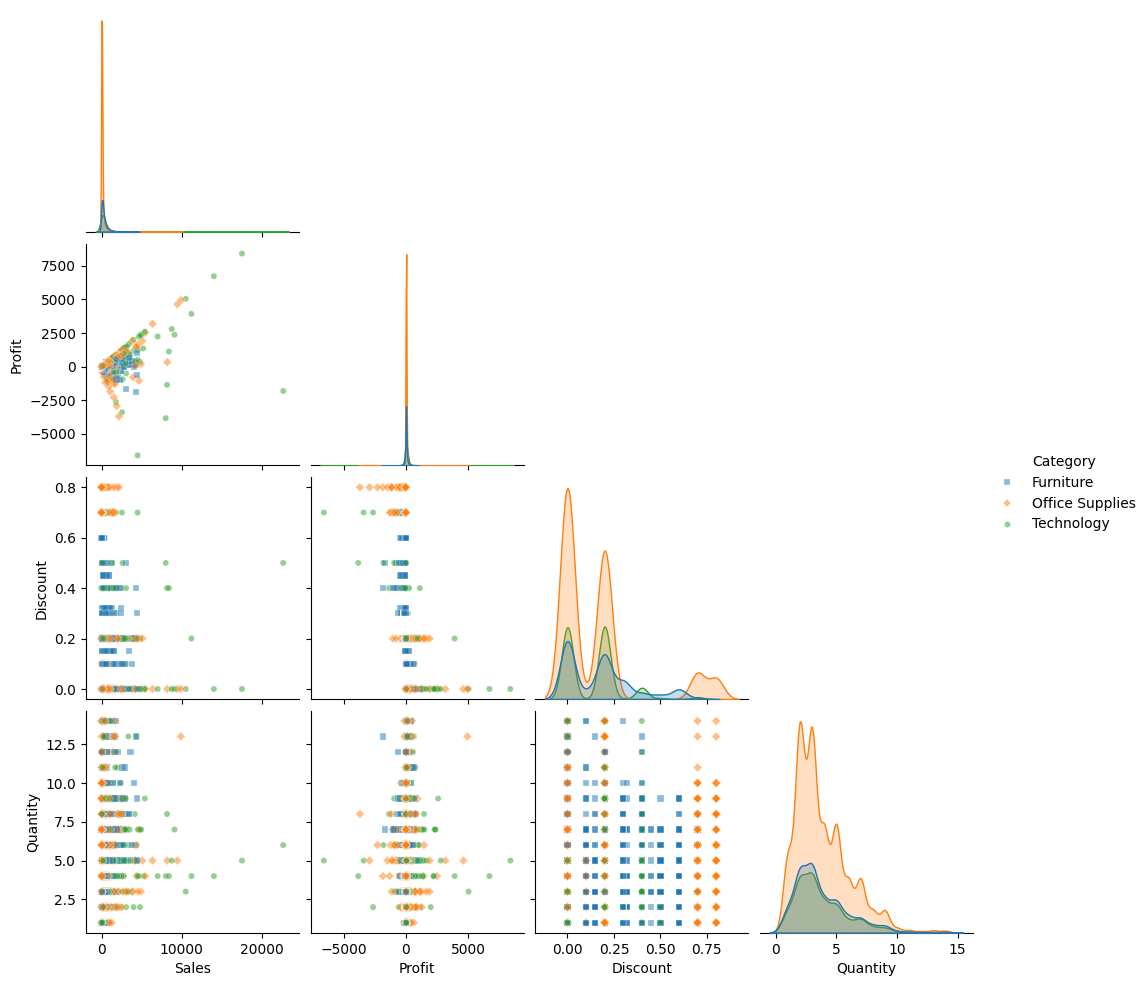

In [135]:
#pairplot
plt.figure(figsize =(10,6))

sns.pairplot(filtered_data, hue = 'Category', corner=True, markers=["s", "D","o"], plot_kws={'s': 20, 'alpha':0.5}, diag_kind = 'kde' ) #DIAGNOL SHOW KDE PLOT

plt.show()

##  Correlation Analysis

In [136]:
corr_matrix = df.corr(numeric_only = True)

<Axes: >

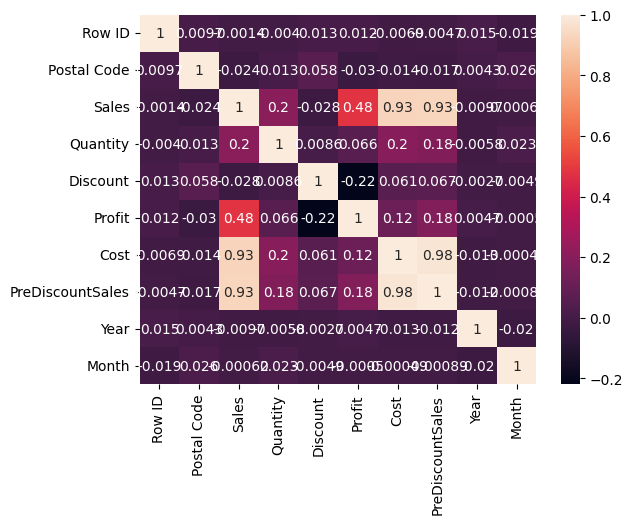

In [137]:
sns.heatmap(corr_matrix, annot = True)

- Profit and Sales are moderately correlated.
- Gross Sales is highly correlated to Cost with pearson correlation coefficient of 0.98. This is expected since higher cost generally reflect in the sale price.
- Rest of the numeric features have a weak correlation.

##  Conditional Analysis

######**What are the average sales per segment across different regions?**

In [138]:
# Regional Per Order/Transaction Sales Distribution by Segment across Regions

pd.pivot_table(order_region_segment, values = 'Total_Sales', index = 'Segment', columns = 'Region', aggfunc = ['mean','median', 'sum'])

mean                                       median           \
Region          Central        East       South        West  Central     East   
Segment                                                                         
Consumer     417.270586  492.157317  440.497682  439.855482  140.136  147.568   
Corporate    454.010956  461.772689  493.465314  465.680978  115.123  163.450   
Home Office  409.025309  501.825693  566.832073  454.225173  152.800  135.351   

                                       sum                           \
Region         South     West      Central        East        South   
Segment                                                               
Consumer     173.870  166.440  252031.4340  350908.167  195580.9710   
Corporate    157.794  177.225  157995.8128  200409.347  121885.9325   
Home Office  148.160  135.936   91212.6440  127463.726   74255.0015   

                          
Region              West  
Segment                   
Consumer     362880.7730  
Corporate    225855.2745  
Home Office  136721.7770

It is observed that:
- Highest sales come from Consumer segment across all regions.
- On average, least sales per order were observed in Central region for the Home Office Segment i.e. approx `$409` while highest average sales interestingly came from the same segment in South region (approximately `$567`) despite least number of orders i.e. 131 total orders. This high average basket value indicates demand of pricier items by Home Office customers in the South as opposed to Central region.

In [139]:
# Purchase Frequency of each Product Sub-Category by Home Office segment in South and Central regions

df[(df['Segment']=='Home Office') & (df['Region'].isin(['South','Central']))].groupby(['Region','Sub-Category'])['Order ID'].count().sort_values(ascending=False)

#Binders are most ordered by Home Office segment in South region and Central Region.

Region   Sub-Category
Central  Binders         69
         Paper           54
South    Binders         48
Central  Phones          42
         Furnishings     39
         Art             38
South    Paper           37
Central  Storage         37
         Accessories     31
South    Furnishings     30
         Phones          28
Central  Chairs          28
South    Accessories     24
         Storage         22
         Art             21
Central  Appliances      21
         Labels          20
         Envelopes       15
         Tables          14
South    Labels          12
         Chairs           9
         Fasteners        9
Central  Bookcases        8
South    Tables           8
Central  Fasteners        7
South    Envelopes        7
Central  Machines         6
South    Supplies         5
Central  Supplies         5
South    Appliances       5
Central  Copiers          4
South    Bookcases        4
         Machines         3
Name: Order ID, dtype: int64

In [140]:
# Unique Order ID data

unique_orders = df.drop_duplicates(subset=["Order ID"], keep='first').reset_index(drop = True)

In [141]:
# Order frequency of each ship mode used by Home Office segment in the South region

unique_orders[(unique_orders['Segment']=='Home Office') & (unique_orders['Region'] == 'South')]['Ship Mode'].value_counts()

,count
Ship Mode,
Standard Class,90
Second Class,23
First Class,12
Same Day,6


 - In South region: binders, papers and furnishings are the most purchased sub-categories by Home office customers. Since this demographic also used standard shipping for most orders which is expected to be the least expensive option (negating the possibility of shipping fees raising AOV), the higher average basket value can be credited to purchase of furnishings due to it's higher comparative price.   

######**How does discount level affect profitability across different categories?**

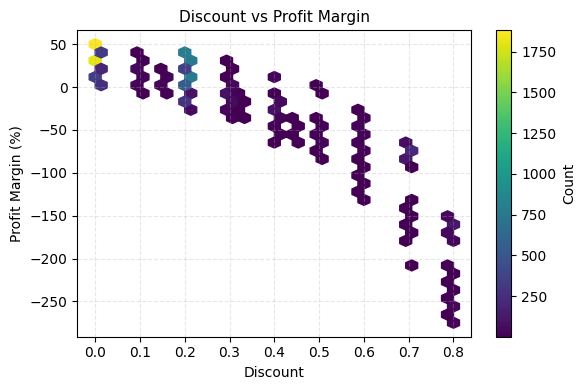

In [142]:
# Discount vs Profit Margin

# set canvas size
plt.figure(figsize=(6, 4))

# plot graph
hb = plt.hexbin(
    x=df_wd['Discount'],
    y=df_wd['Profit Margin'],
    gridsize=30,
    cmap='viridis',
    mincnt=1
)

# customize plot
plt.colorbar(hb, label='Count')
plt.xlabel('Discount')
plt.ylabel('Profit Margin (%)')
plt.title('Discount vs Profit Margin', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)

# display plot
plt.tight_layout()
plt.show()

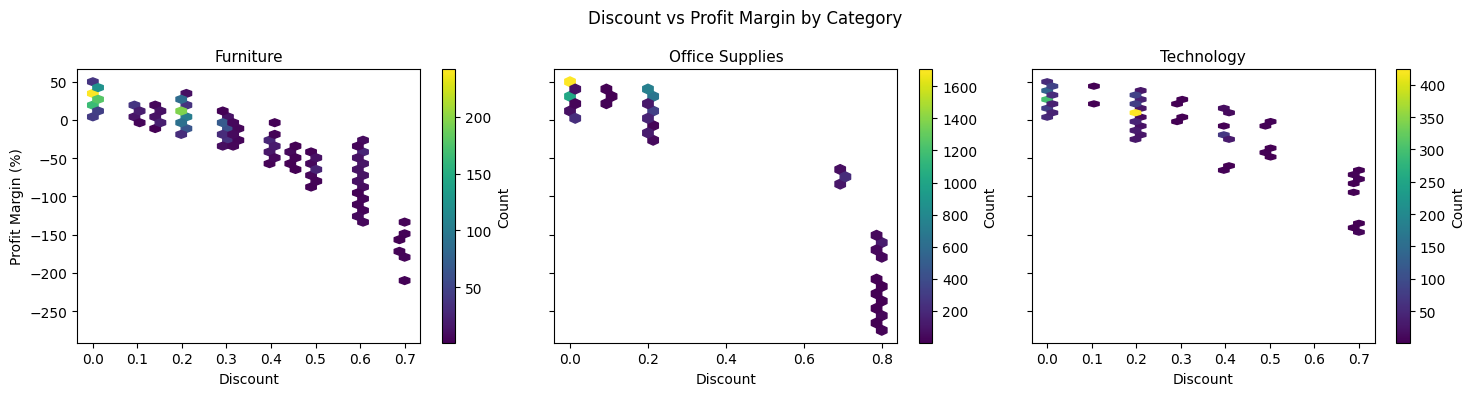

In [143]:
# Discount vs Profit Margin aross Product Categories

categories = df_wd['Category'].unique()
n = len(categories)

#create subplots
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), sharey=True)


# plot graphs
for i, cat in enumerate(categories):
    ax = axes[i]
    subset = df_wd[df_wd['Category'] == cat]
    hb = ax.hexbin(
        subset['Discount'], subset['Profit Margin'],
        gridsize=30, cmap='viridis', mincnt=1
    )
    ax.set_title(cat, fontsize=11)
    ax.set_xlabel("Discount")
    if i == 0:
        ax.set_ylabel("Profit Margin (%)")
    fig.colorbar(hb, ax=ax, label='Count')

# customize plot
#mplcursors.cursor(hover=True)
fig.suptitle("Discount vs Profit Margin by Category", fontsize=12)

# display plot
plt.tight_layout()
plt.show()

**Guide to analyze hexbin plot**
- Dense areas (bright spots) = most common discount–profit margin combos.
- If high discounts cause negative margins, it's a red flag.
- Some categories might tolerate discounts better due to higher markups.
- Look for trends—does profit steadily drop as discount increases?
- Look for sub-categories where higher discounts severely reduce profitability.
- If you see very low or negative margins at high discounts, consider flagging them for discount policy review.
- Patterns may differ across categories, helping target pricing strategies.
- If you see clusters of high discount & low/negative margin, that’s a concern.

**Technology:**
- Even with moderate to high discounts, profit margins generally stay positive
which shows Technology category handles discounts better, maintaining reasonable margins even at discount levels of 40%-60%.

**Furniture:**
- As discounts increase, profit margins sharply decrease.
- High discount levels (≥40%) frequently lead to significant losses (margins as low as -200%).

**Office Supplies:**
- Profit margins remain positive at low discounts but drop drastically at higher discounts (≥ 70%).
- Most transactions cluster around 0–20% discounts, and high-discount instances correlate with large losses.
- Cluster of high discounted orders (~80%) resulting in heavy losses (-150% to 250% margin) calls for immediate action.

**Recommendations:**
- Review discount policy: For furniture and office supply categories, discount levels should be capped at no higher than 20-25% to prevent significant losses, while higher discounts of upto 45-50% can be offered on technology products.
- Product bundling or value-added offers can be offered for office supply items instead of flat discounts to drive demand while safeguarding profitability.
- Technology products generally have higher markup which provides cushion to margins at higher discounts, hence leverage discount to boost sales volume for tech products.


######**What percentage of high discount orders (>30%) result in negative profit?**


In [144]:
# Adding Profit column

subset_profit_wd  = weighted_discounts.merge(df.groupby('Order ID')['Profit'].sum(), on = 'Order ID')

In [145]:
# Filtering high-discount orders

df_high_discount = subset_profit_wd[subset_profit_wd['Weighted Discount Rate'] > 0.3].reset_index(drop=True)

In [146]:
# Proportion of high-discount orders resulting in a loss or profit

loss = df_high_discount[df_high_discount['Profit'] < 0].shape[0]   #664 high discount orders (>30%) result in loss
profit = df_high_discount[df_high_discount['Profit'] > 0].shape[0] #51 high discount orders (>30%) result in profit

print(f"{(loss/df_high_discount.shape[0])*100:.1f}% of high discount orders (>30%) result in loss while only {(profit/df_high_discount.shape[0])*100:.1f}% result in profit.")

92.9% of high discount orders (>30%) result in loss while only 7.1% result in profit.


- This signifies the need to reconsider the discount policy specifically across categories discussed earlier.

######**Which sub-categories have the highest loss percentage and highest profit percentge compared to sales i.e. highest and lowest profit margin?**

In [147]:
subcategory = df.groupby('Sub-Category')[['Profit', 'Sales', 'Cost']].sum().reset_index()

# Filter only sub-categories with negative total profit
loss_df = subcategory[subcategory ['Profit'] < 0]

# Calculate Loss Percentage
loss_df['Loss %'] = (-loss_df['Profit'] / loss_df['Sales']) * 100

# Sort by Loss Percentage descending
loss_df = loss_df.sort_values(by='Loss %', ascending=False)


<ipython-input-147-d369035d038e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df['Loss %'] = (-loss_df['Profit'] / loss_df['Sales']) * 100


In [148]:
# Display result

loss_df.set_index('Sub-Category')

,Profit,Sales,Cost,Loss %
Sub-Category,,,,
Tables,-17725.4811,206965.5320,224691.0131,8.564460
Bookcases,-3472.5560,114879.9963,118352.5523,3.022768
Supplies,-1189.0995,46673.5380,47862.6375,2.547695


In [149]:
# Filter only sub-categories with positive total profit
profit_df = subcategory[subcategory['Profit'] > 0]

# Calculate Profit Percentage
profit_df['Profit %'] = (profit_df['Profit'] / profit_df['Sales']) * 100

# Sort by Profit Percentage descending
profit_df = profit_df.sort_values(by='Profit %', ascending=False)

<ipython-input-149-ba9f521e3b9a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_df['Profit %'] = (profit_df['Profit'] / profit_df['Sales']) * 100


In [150]:
# Display result

profit_df.set_index('Sub-Category').head(4)

,Profit,Sales,Cost,Profit %
Sub-Category,,,,
Labels,5546.2540,12486.312,6940.0580,44.418672
Paper,34053.5693,78479.206,44425.6367,43.391837
Envelopes,6964.1767,16476.402,9512.2253,42.267582
Copiers,55617.8249,149528.030,93910.2051,37.195585


- Tables, bookcases and supplies have the highest negative profit margin e.g, on average for every `$1` the store earns by selling tables, it loses `$0.086`.
- Labels, Papers and Envelopes have the highest profit margin e.g. on average the store earns `$0.44` on top of every `$1` earned by selling labels.

######**What is the probability of receiving a profit/loss given a discount rate?**


In [151]:
# Tag profit label

df['Profit_Label'] = df['Profit'].apply(lambda x: 'Profit' if x > 0 else 'Loss')

In [152]:
# Creating dataframe for frequency of orders that made a profit/loss and total orders for each discount level

profit_loss_by_discount = df.groupby(['Discount', 'Profit_Label'])['Order ID'].count().unstack().fillna(0).merge(
    df.groupby('Discount')['Order ID'].count().rename('Total'), on = 'Discount')

In [153]:
# Adding Profit/Loss Probability

profit_loss_by_discount['Profit Probability (%)'] = ((profit_loss_by_discount['Profit']/profit_loss_by_discount['Total'])*100).round(2)
profit_loss_by_discount['Loss Probability (%)'] = ((profit_loss_by_discount['Loss']/profit_loss_by_discount['Total'])*100).round(2)

In [154]:
# Display result

profit_loss_by_discount

,Loss,Profit,Total,Profit Probability (%),Loss Probability (%)
Discount,,,,,
0.00,30.0,4768.0,4798,99.37,0.63
0.10,4.0,90.0,94,95.74,4.26
0.15,17.0,35.0,52,67.31,32.69
0.20,524.0,3133.0,3657,85.67,14.33
0.30,221.0,6.0,227,2.64,97.36
0.32,27.0,0.0,27,0.00,100.00
0.40,180.0,26.0,206,12.62,87.38
0.45,11.0,0.0,11,0.00,100.00
0.50,66.0,0.0,66,0.00,100.00


The probability of receiving a profit/loss given a discount rate is as follows:

 - The probability of making a loss increases with discount rate generally.
 - 40% discount is the threshold beyond which (as a whole across all product categories) the superstore makes no profit, however, this can be further drilled down to flag specfic categories and sub-categories to be able to tailor discount policy accordingly.


######**Among unprofitable orders, which categories or regions dominate?**

In [155]:
# Filtering loss-making orders

region_loss = order_region_segment[order_region_segment['Total_Profit']<0]

In [156]:
# Proportion of loss-making orders across Regions

region_loss['Region'].value_counts(normalize=True)*100

,proportion
Region,
Central,40.508806
East,30.528376
West,15.264188
South,13.698630


- The highest number of unprofitable orders come from Central region (40%) while least from the South region (13%).

######**What is the average delivery delay (Ship Date - Order Date), and does it impact customer segments or product types?**

In [157]:
# Changing data type of Delay column

unique_orders['Delay']= unique_orders['Delay'].astype(str)

In [158]:
# Order frequency across each state shipped via Standard Class which by number of days delayed

delay_orders = pd.pivot_table(unique_orders[unique_orders['Ship Mode'] == 'Standard Class'], values = 'Order ID', index = 'State', columns = 'Delay', aggfunc = ['count']).fillna(0)

In [159]:
delay_orders['Sub_Total'] = delay_orders[[('count', '3 days'),
            ('count', '4 days'),
            ('count', '5 days'),
            ('count', '6 days'),
            ('count', '7 days')]].sum(axis=1)

In [160]:
# Grabbing inner column label in multi-index column label

delay_orders.columns = [lvl1 for lvl0, lvl1 in delay_orders.columns]

In [161]:
# Renaming for clarity

delay_orders.rename(columns={'': 'Total'}, inplace=True)

In [162]:
# Proportion of orders delayed by 7 days across each state

for index, row in delay_orders.iterrows():
 print(index, f"{((row['7 days']/row['Total'])*100):.2f}%")

Alabama 19.05%
Arizona 16.42%
Arkansas 20.00%
California 11.31%
Colorado 12.20%
Connecticut 12.50%
Delaware 3.45%
District of Columbia 0.00%
Florida 7.20%
Georgia 12.50%
Idaho 0.00%
Illinois 9.25%
Indiana 6.67%
Iowa 10.00%
Kansas 11.11%
Kentucky 12.50%
Louisiana 0.00%
Maine 0.00%
Maryland 7.14%
Massachusetts 10.26%
Michigan 8.33%
Minnesota 16.13%
Mississippi 10.53%
Missouri 6.67%
Montana 16.67%
Nebraska 8.33%
Nevada 33.33%
New Hampshire 11.11%
New Jersey 11.90%
New Mexico 6.25%
New York 9.59%
North Carolina 10.00%
North Dakota 0.00%
Ohio 10.08%
Oklahoma 13.04%
Oregon 2.78%
Pennsylvania 10.29%
Rhode Island 25.00%
South Carolina 0.00%
South Dakota 0.00%
Tennessee 13.85%
Texas 8.74%
Utah 0.00%
Vermont 0.00%
Virginia 6.25%
Washington 13.55%
West Virginia 0.00%
Wisconsin 5.71%
Wyoming 0.00%


In [163]:
# Preparing required data

# initializing lists
proportion = []
states = []

# looping through dataframe
for index, row in delay_orders.iterrows():
 states.append(index)
 proportion.append(row['7 days']/row['Total'])

In [164]:
# top 10 states by proportion of standard delivery orders delayed by 7 days

pd.Series(data = proportion,index = states, name = "Proportion of Orders Delivered in 7 Days").sort_values(ascending=False).head(10)

,Proportion of Orders Delivered in 7 Days
Nevada,0.333333
Rhode Island,0.250000
Arkansas,0.200000
Alabama,0.190476
Montana,0.166667
Arizona,0.164179
Minnesota,0.161290
Tennessee,0.138462
Washington,0.135484
Oklahoma,0.130435


- Across all orders that have been shipped, on average it takes nearly 4 days for delivery.
- Standard class is the most widely used shipping mode across regions hence it is studied to narrow states where it is least efficient:
  - The store needs to focus on Nevada (33%), Rhode Island (25%), Arkansas (20%) and Alabama (19%) to eliminate logistical inefficiencies due to highest proportion of standard delivery orders being delayed by 7 days in these states to minimise customer dissatisfaction and increase customer lifecycle.

######**Are there any sub-categories that are profitable despite high discounting?**

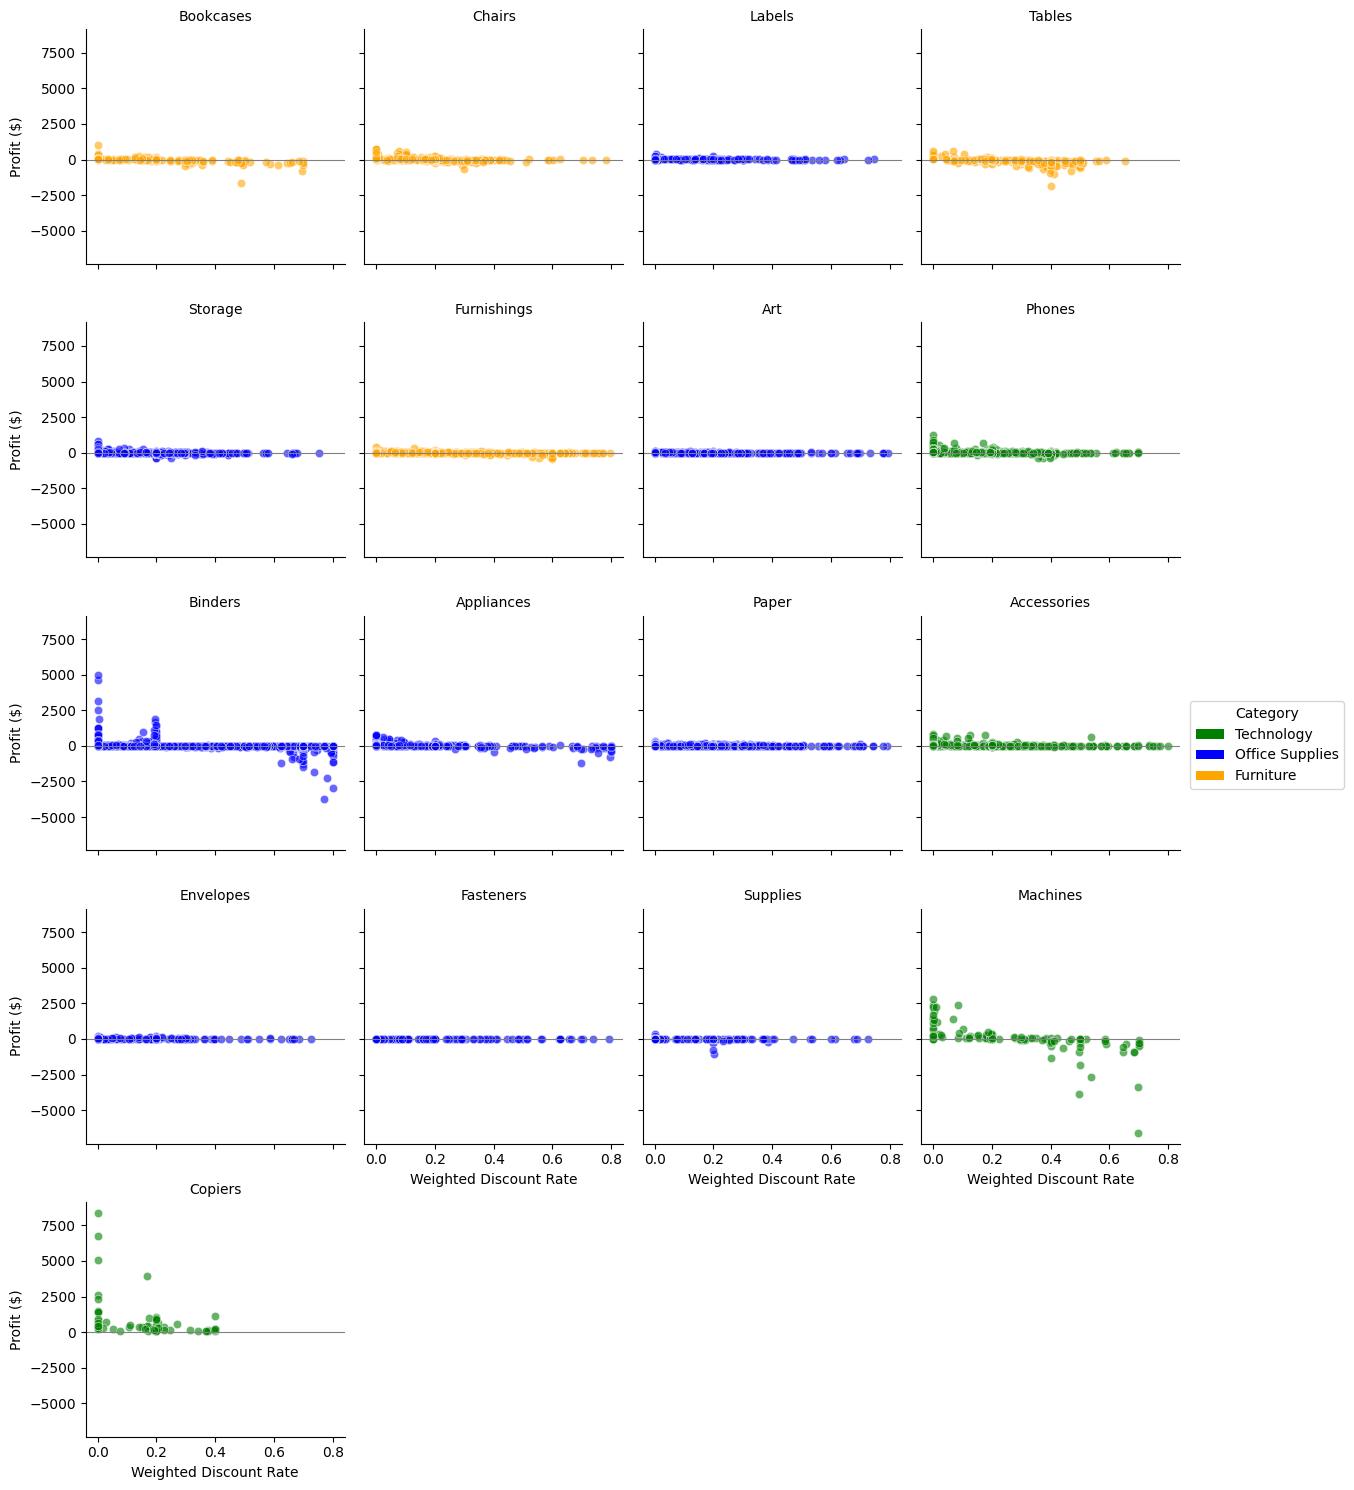

In [165]:
# Import library
from matplotlib.patches import Patch

hue_order = ['Technology', 'Office Supplies', 'Furniture']    # manually setting hue_order
palette = {                                                   # defining custom palette
    'Technology': 'green',
    'Office Supplies': 'blue',
    'Furniture': 'orange'
}

# Create FacetGrid object, 'g'
g = sns.FacetGrid(df_wd, col='Sub-Category', hue="Category",col_wrap=4,hue_order=hue_order, palette = palette)

# Mapping a plot to each facet
g.map_dataframe(sns.scatterplot, "Weighted Discount Rate", "Profit", alpha=0.6)

# Customizing plot
g.set_axis_labels("Weighted Discount Rate","Profit ($)")
g.set_titles(col_template="{col_name}")

# Adding reference line
g.refline(y=0, linestyle="-", color="gray", linewidth=0.8)

# Manually create legend with color markers
legend_elements = [Patch(facecolor=palette[cat], label=cat) for cat in hue_order]
g.fig.legend(handles=legend_elements, title='Category', loc='center right', bbox_to_anchor=(1.13, 0.5))

#g.add_legend()  # Add legend
#g._legend.set_bbox_to_anchor((1.13, 0.5))  # Move outside to the right (x, y)
#g._legend.set_title('Category')

# Show plot
g.tight_layout()
sns.set_style("darkgrid")
plt.show()

- Copiers are generally profitable despite being discounted up to 40%.
- Certain Technology products like machines, certain office supply products such as binders and certain furniture products such as bookcases and tables are non-profitable at higher discounts.
- Rest of SKUs are generally stable in their profits across low and high discount levels.

##  Business Insights and Recommendations

####**Executive Summary**

An analysis of 9,994 sales records from 2014 to 2017 for the Retail Superstore chain reveals an overall profit growth of approximately `$25,000`. However, a notable decline in profitability was observed in Q4 of 2017, particularly within the Technology and Office Supplies categories.

Among product segments, Copiers generated the highest average sales value, approximately `$1,100` per order. In contrast, Tables, Bookcases, and Supplies incurred the highest per-order losses. Furthermore, discounting patterns show a strong correlation with profitability: 92.9% of orders with discounts exceeding 30% result in a loss, and the store experiences no profit at discount levels beyond 40%, across all product categories.

To support sustained profitability and strategic growth, the company should consider:

- Implementing data-driven, category-specific discounting strategies;

- Expanding efforts in the Central region, which shows potential for targeted growth;

- Conducting a root cause analysis to address consistently low profit margins within the Standard shipping class, with the aim of optimizing logistics and pricing decisions.

####**Insights Deep-Dive**

##### **Seasonal Trend**

Profitability:
- **Overall Growth**: Profit shows a general increasing trend from 2014 to 2017, with significant spikes in late 2016 and late 2017.
- **Seasonality**: Q4 of each year tends to have a strong spike in profits, suggesting seasonal effects (possibly due to holiday sales).
- **Recent Stability**: In 2017 Q3 and Q4, profits stabilize at a relatively high level compared to earlier years.
- **Product Level Performance**:
 - Over the last two years, furniture items have comparatively yielded lesser profits ranging between `$-2500` and `$2800`.
 - Although technology is a high profit yielding category but is also the most volatile, where some months especially Oct 2016 and Mar 2017 had record profit of `$11,700` and `$11,000` respectively. Nov 2016 and Apr 2017 however, dented the superstore bearing losses of `$1500` and `$2600` respectively.
 - Office Supplies profits have also been generally on the rise, with Dec 2016 bringing in highest profit of approx `$11,460`.
 - More recently over the last couple of months, the profits for technology and office supply items have dropped while that of furniture has risen.
 - Office supply items recent drop in profit is due to Binders which despite second highest sales in Q4 has caused superstore to loose approximately `$700`.

Sales:
- **Steady Growth**: Sales show a strong and relatively consistent upward trend over the years.
- **Sharp Drops**: Noticeable sales drops occur in Q1 of each year.
- **Acceleration**: The sales growth rate accelerated particularly in 2017.

Profit Margin:
- **Initial Stability, Later Volatility**: Profit margins are fairly stable around 12–14% from 2014 to early 2016 but become much more volatile afterward.
- **High Peaks**: A major peak occurs in 2017 Q1 (around 19%), suggesting exceptional efficiency/profitability for that quarter.
-**Decoupling**: Sales and profits are growing, but margins are shrinking, indicating rising costs or inefficiencies.
- **Recent Decline**:
 - After peaking, profit margins decreased sharply towards the end of 2017 despite high sales.
 - The steepest drop in average profit margin  in the last quarter of 2017 is observed in Consumer segment in Central region (-3% to -17.6%) due to high discounts (60%-80%) given to it, and Home Office segment in South region (19% to 3%).
 - In South region, the discounts given to Home Office segment have ranged between 0-20% with only a couple of orders that have been discounted more than 50%. This indicates that the profit margin has been impacted by other factors such as costs/sale of low margin products there.



##### **Overall Product Performance**

- Technology category as a whole is the highest selling and earns highest profit on per order basis with average order value of approximately `$219` and profit of nearly `$31`.

- Copier (sub-category bringing in most sales on average of `$1100` per order) is being most ordered by consumers.

- Despite least average sales per order, Office Supplies items have the the highest profit margin per order on average of roughly `$31`.

- Furniture has lowest average profit margin of `$10` despite roughly equal average sales as technology items, per order.

##### **Poduct Portfolio Analysis**

- Binders, papers and furnishings are the most purchased sub-categories by Home office customers in the South region, which is the demographic bringing in highest average sales per order (AOV).

- Since this demographic also used standard shipping for most orders which is expected to be the least expensive option (negating the possibility of shipping fees raising AOV), the higher average basket value can be credited to purchase of furnishings due to it's higher comparative price.

- Tables, bookcases and supplies have the highest negative profit margin e.g, on average for every `$1` the store earns by selling tables, it loses `$0.086`, while labels, papers and envelopes have the highest profit margin e.g. on average the store earns `$0.44` on top of every `$1` earned by selling labels.

- Copiers are generally profitable despite being discounted up to 40%.
Specific products including machines (tech), binders (office supply), bookcases and tables (furniture) are non-profitable at higher discounts.

##### **Regional Analysis**

- Largest order volume originates from the West region (32%) closely followed by East region (28%).

- West region outperforms others with approximately 15% more profit generated compared to East region which is the next most profitable region on per order basis.

- Central Region is the most under-performing region with cumulative profit of approx `$40,000` which is roughly 3x lesser than West region, and yields the highest number of unprofitable orders (40%).

- In the East, South and West regions, consumer segment brings in the biggest share of profit per transaction while corporate segment is biggest profit contributor in Central region (despite consumer segment bringing in the highest order volume).

- Unlike other regions where median profit margin (per order basis) is stable across segments, in Central region: the profit margin for Consumer segment (`$9.5`) is nearly half of Home Office segment (`$19`).

- On average, least sales per order are observed in Central region for the Home Office Segment i.e. approx (`$409`) while highest average sales interestingly come from the same segment in South region (approximately `$567`) despite least number of orders i.e. 131 total orders.

##### **Customer Segmentation**

- Consumer segment brings in the largest order volume across all regions and also the most profit (`$0.13` million to date which is twice that of the Home Office segment).

- On per order basis, highest median profit comes from corporate orders (`$16.8`) which is expected since they either buy bulk quantity or items higher on the price band.

- Besides standard class, all ship modes yield high average profits per order in the Home office segment (excess of `$85`). First class shipping yields `$93` per order on average which is the highest across board.

- In Corporate segment, same day shipping yields significantly lower profits per order on average (`$31`, lowest across board) compared to other shipping modes that yield comparable profits of roughly `$60`.

- Consumer segment yields comparative profits per order on average through different ship modes ranging between `$50` (second-class shipping) to `$63` (same day shiping).

##### **Discount Effectiveness**

- The probability of making a loss increases with discount rate generally.
40% discount is the threshold beyond which (as a whole across all product categories) the superstore makes no profit.

- Overall, 92.9% of high discount orders (>30%) result in loss while only 7.1% result in profit.

- Technology is most sensitive to discounts, while furniture and office supplies appear less affected overall.

- Technology category displays a noticeable negative trend where higher discounts appear to have a more direct and negative impact on profitability compared to furniture and office supplies.

- For furniture items, high discount levels (≥40%) frequently lead to significant losses (margins as low as -200%).

- For office Supply items, profit margins remain positive at low discounts but drop drastically at higher discounts (≥ 70%) resulting in heavy losses (-150% to -250% margin) which calls for immediate action.

##### **Shipping Mode and Delays Trend**

- Across all orders that have been shipped, on average it takes nearly 4 days for delivery.

- Standard Class yields the lowest profit margin despite highest total sales and profit (since it is most widely used). This could be because it is cost-intensive (eating into profits due to high logistics costs from shipping partners).

- Despite similar AOV and median profit per transaction/order, Standard class has lowest profit margin (`$12.1`) while First class has highest profit margin (`$13.9`) per transaction/order basis.

- Nevada (33%), Rhode Island (25%), Arkansas (20%) and Alabama (19%) are most susceptible to order delays evident by highest proportion of standard delivery orders being delayed by 7 days in these states.

- Central region has been struggling in making profit compared to other regions amongst all shipping modes with with first class and same day shipping yielding lowest average profits per order across the board, `$21` and `$25` respectively.

- Same day shipping is out-performing in East and West bringing in roughly `$108` and `$91` per order, respectively, however, in South it has caused significant loss, on average the superstore loses `$45` per order that is shipped same day.


####**Recommendations**

##### **Product Startegy**

- Plan on raising inventory levels of office supplies items but re-consider pricing or discount of furniture items (specifically low profit earners at higher discounts such as bookcases and tables).
- Specifically, focus on efficent inventory forecasting for high-sale items such as Copiers and consider phasing out Machines from the product portfolio due to significant losses in range of `$2000`  to `$4000`.
- Although technology profits are volatile, the store can rely on phone sales for being majorly profitable.
- Focus marketing efforts on SKUs with high profit-margins across all regions such as labels, paper, and envelopes.
- Re-evaluate discount policy or re-negotiate costs with manufacturers/logistic partners for low profit-margin SKUs including tables, bookcases and supplies.

##### **Regional Customer Growth and Retention**

- Target Consumer segment (specially in the Central region) with product bundling offers of high-margin products or upsell incentives to boost average order basket value such as free shipping for minimum spend in specific high margin product categories.

- Ensure the longevity of Corporate segment's high profitability in the Central region by offering incentized offerings such subscription-like contracts or flat discounts on bulk purchases of high-margin products to safeguard profitability.

-  Replicate effective strategies of Home Office segment from the South region in Central region to boost it's average order value including product pricing, discount thresholds and limited time incentives.

- Leverage recommendation engines to offer personalised product offerings and advertisments based on purchase patterns towards Consumer segment specially in the West and East regions which bring in the highest order volume and overall profit.

##### **Discount Optimization**

- Implementation of tailored discounting strategies are necessary for different product categories to optimize profitability:
 - For Technology products:
   - Higher markup provides cushion to margins at higher discounts, hence leverage discount (up to  45-50%) to boost sales volume.
   - Use time-bound promotions (e.g., "48-hour flash sale") and bundle with services (e.g., warranties) to limit margin erosion.
 - For Furniture and Office Supplies:
   - Cap discount levels at no higher than 20-25% to prevent significant losses.
   - Offer product bundling or value-added offers for office supply items instead of flat discounts to drive demand while safeguarding profitability.


##### **Addressing Logistical Shortcomings**

- Cut down logistical inefficiencies for same day shipping in the South region by adopting best practises from the West and the East such as warehouse processes and inventory allignment with the demand tracked most preferably in real-time.

- Investigate the driver of low profit margin for Standard class shipping:
 - Re-negotiate bulk rate discounts for standard class carriers to improve the profit margin if it is caused by higher fixed logistical costs.
 - Consider bundling offers with high-margin products against incentives such as limited discounts or shipping fee cuts if majorly low-margin product SKUs are being purchased through standard shipping mode.
 - If driven by high promotional discounts, shift toward loyalty-based or reward-point based incentives instead of flat discounts.

- Central region calls for root cause identification:
  -  Identify cost inefficiencies (e.g., last-mile delivery, warehouse distance, low route density) and benchmark these costs against other regions.

 - Reassess Product-Shipping Fit: if low-margin products are disproportionately being shipped via First Class or Same Day shipping then restricting them for such SKUs is recommended.


####**Assumptions, Caveats and Next Steps**

**Discount Application Assumption**: It is assumed that the discount value in each transaction record is applied to the total quantity purchased, not just to a single unit.

**Cost Data Limitation**: The absence of cost-related data—specifically unit cost price (COGS) and logistics costs—limits the ability to fully explain certain observations. For example, the low profit margins associated with the Standard shipping class cannot be conclusively attributed to discounting without ruling out cost as a potential driver. Similarly, identifying low-margin SKUs is constrained by this data gap.

**Next Steps and Recommendations**: To validate or refute potential business loss drivers, such as the hypothesis that aggressive discounting on items primarily shipped via Standard class is reducing profit margins, the store should consider conducting further statistical analyses. This includes A/B testing or controlled experiments to determine the true impact of discount strategies on profitability.